# Military Aircraft Detection

**Identitas Mahasiswa:**
* **Nama Lengkap:** Bayu Ardiyansyah
* **NIM:** 202210370311025
* **Jurusan:** Informatika
* **Universitas:** Universitas Muhammadiyah Malang

**Deskripsi Proyek:**
Proyek ini bertujuan untuk membangun sistem klasifikasi pesawat militer secara *fine-grained* mencakup berbagai jenis pesawat (96 kelas). Notebook ini mencakup proses EDA komprehensif, implementasi tiga arsitektur model (Custom CNN, MobileNetV2, dan EfficientNetB0), serta evaluasi mendalam menggunakan metrik standar industri dan analisis teoretis tingkat lanjut.

## Import Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

"""
Konfigurasi Environment:
Memastikan GPU digunakan jika tersedia untuk mempercepat proses training.
"""
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU Detected and Configured.")
    else:
        print("No GPU Detected. Running on CPU.")
except RuntimeError as e:
    print(e)

2025-12-18 16:49:33.681747: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-18 16:49:33.691959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766051373.703469   20858 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766051373.706786   20858 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766051373.716336   20858 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

GPU Detected and Configured.


## Exploratory Data Analysis (EDA)

Total Gambar Ditemukan: 39482
Total Kelas (Tipe Pesawat): 96


/tmp/ipykernel_20858/2137607251.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts[:20].index, y=class_counts[:20].values, palette='viridis')


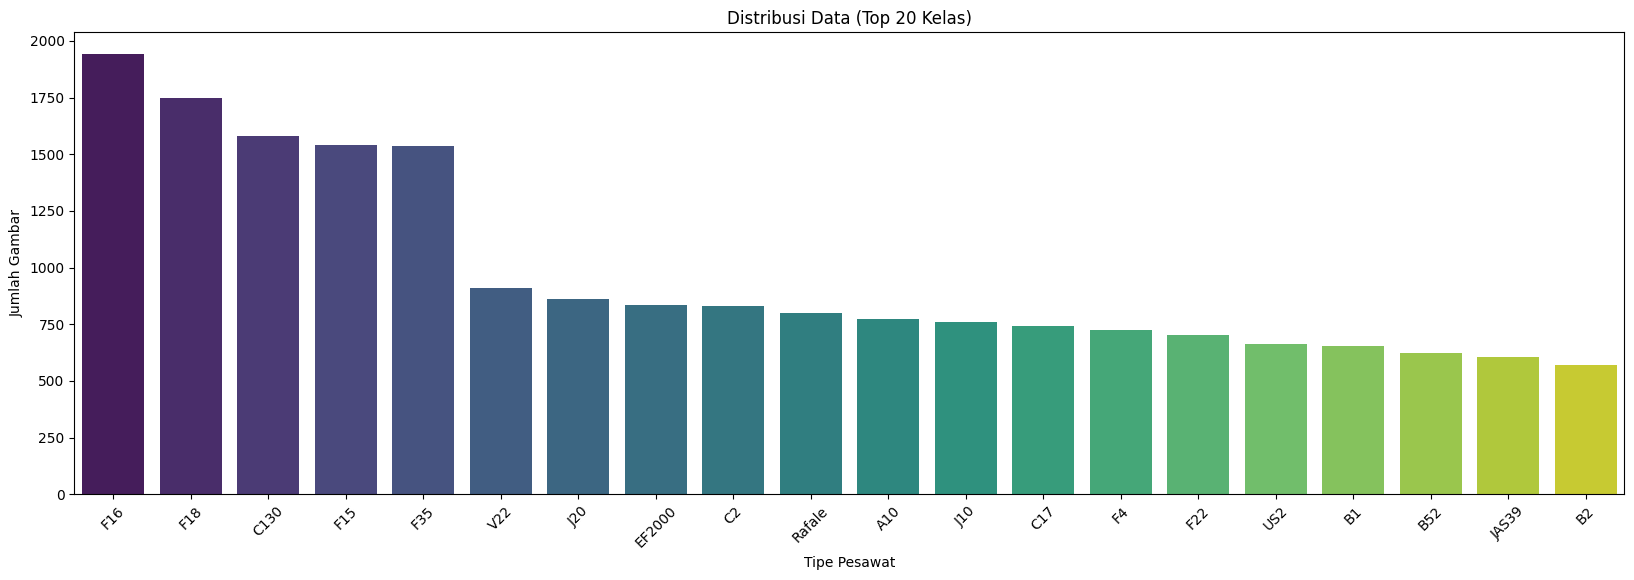

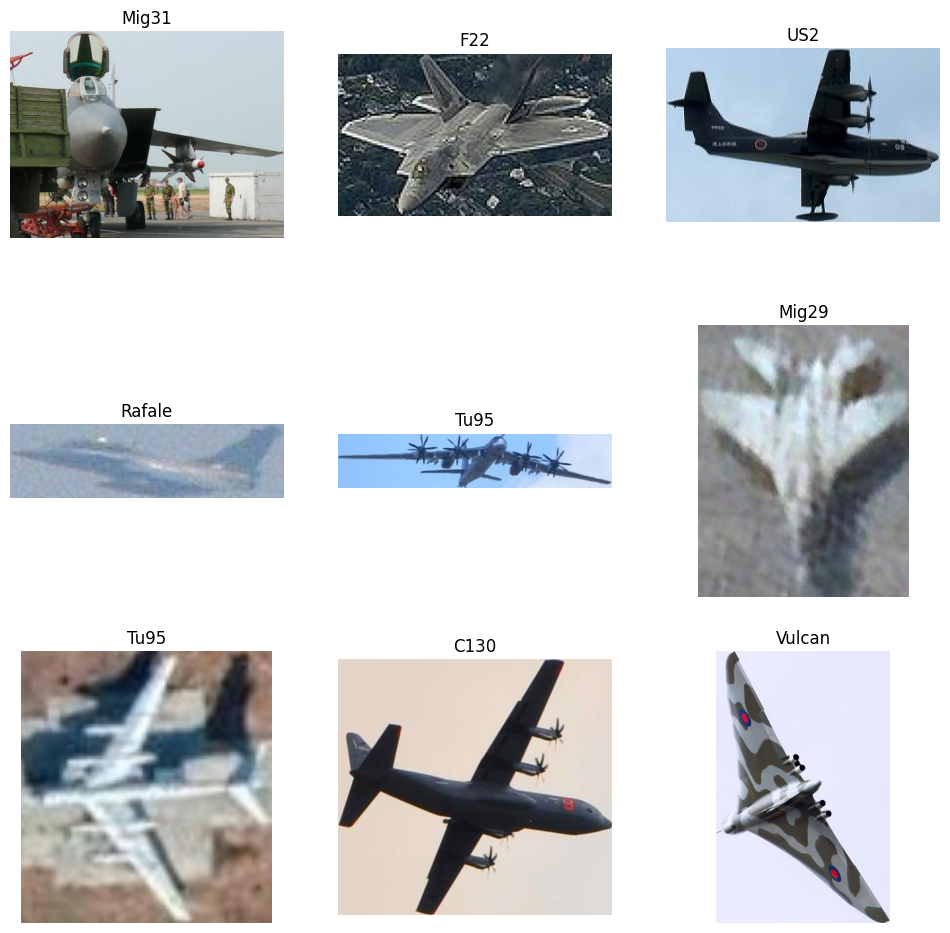

[INFO] Jumlah data (39482) memenuhi syarat minimal.


In [2]:
"""
Path Configuration:
Diasumsikan folder 'crop' berisi sub-folder berdasarkan nama kelas.
Struktur: D:/.../crop/{class_name}/{image}.jpg
"""
DATASET_DIR = '../Dataset/crop' 

def explore_dataset(directory):
    """
    Melakukan analisis eksploratif terhadap struktur dataset.
    
    Args:
        directory (str): Path direktori utama dataset.
        
    Returns:
        pd.DataFrame: Dataframe berisi path file dan label kelas.
    """
    file_paths = []
    labels = []
    
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    file_paths.append(os.path.join(class_dir, filename))
                    labels.append(class_name)
    
    df = pd.DataFrame({'filepath': file_paths, 'label': labels})
    
    print(f"Total Gambar Ditemukan: {len(df)}")
    print(f"Total Kelas (Tipe Pesawat): {df['label'].nunique()}")
    
    plt.figure(figsize=(20, 6))
    class_counts = df['label'].value_counts()
    
    # Visualisasi Top 20 Kelas Terbanyak
    sns.barplot(x=class_counts[:20].index, y=class_counts[:20].values, palette='viridis')
    plt.title('Distribusi Data (Top 20 Kelas)')
    plt.xticks(rotation=45)
    plt.ylabel('Jumlah Gambar')
    plt.xlabel('Tipe Pesawat')
    plt.show()
    
    # Menampilkan Sampel Gambar
    plt.figure(figsize=(12, 12))
    sample_df = df.sample(9)
    for index, (i, row) in enumerate(sample_df.iterrows()):
        plt.subplot(3, 3, index + 1)
        img = plt.imread(row['filepath'])
        plt.imshow(img)
        plt.title(row['label'])
        plt.axis('off')
    plt.show()
    
    return df

# Eksekusi EDA
df_metadata = explore_dataset(DATASET_DIR)

"""
Validasi Persyaratan Jumlah Data:
Sesuai instruksi, dataset minimal 5.000 data.
Jika kurang, Augmentasi Data akan diaktifkan secara agresif pada tahap Generator.
"""
DATA_COUNT = len(df_metadata)
if DATA_COUNT < 5000:
    print(f"[INFO] Jumlah data ({DATA_COUNT}) di bawah 5.000. Augmentasi data akan dimaksimalkan.")
else:
    print(f"[INFO] Jumlah data ({DATA_COUNT}) memenuhi syarat minimal.")

## Data Preprocessing & Augmentation

In [3]:
"""
Konfigurasi Hyperparameter Global
"""
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
RANDOM_SEED = 42

def create_generators(dataframe, batch_size, img_size):
    """
    Membuat ImageDataGenerator untuk Train, Validation, dan Test.
    Menggunakan split 70:20:10 atau 80:20 (disini kita pakai flow_from_dataframe dengan split manual).
    
    Args:
        dataframe (pd.DataFrame): Dataframe master.
        batch_size (int): Ukuran batch.
        img_size (tuple): Dimensi target gambar.
        
    Returns:
        train_gen, val_gen, test_gen: Generator objek.
    """
    from sklearn.model_selection import train_test_split
    
    # Split Dataset
    train_df, test_df = train_test_split(dataframe, test_size=0.15, stratify=dataframe['label'], random_state=RANDOM_SEED)
    train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df['label'], random_state=RANDOM_SEED)
    
    print(f"Data Training: {len(train_df)}")
    print(f"Data Validation: {len(val_df)}")
    print(f"Data Testing: {len(test_df)}")
    
    # Augmentasi Data untuk Training (Penting untuk memenuhi variasi data jika < 5000)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Hanya rescale untuk Validasi dan Testing
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filepath',
        y_col='label',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    
    val_gen = val_test_datagen.flow_from_dataframe(
        val_df,
        x_col='filepath',
        y_col='label',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_gen = val_test_datagen.flow_from_dataframe(
        test_df,
        x_col='filepath',
        y_col='label',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_gen, val_gen, test_gen

train_generator, val_generator, test_generator = create_generators(df_metadata, BATCH_SIZE, (IMG_HEIGHT, IMG_WIDTH))
NUM_CLASSES = len(train_generator.class_indices)

Data Training: 28525
Data Validation: 5034
Data Testing: 5923
Found 28525 validated image filenames belonging to 96 classes.
Found 5034 validated image filenames belonging to 96 classes.
Found 5923 validated image filenames belonging to 96 classes.


## Model 1 - Neural Network Base (Custom CNN)

In [4]:
def build_custom_cnn(input_shape, num_classes):
    """
    Membangun arsitektur CNN sekuensial dari awal (Non-Pretrained).
    Dilengkapi dengan BatchNormalization untuk stabilitas training dan Dropout untuk regularisasi.
    """
    model = Sequential([
        Input(shape=input_shape),
        
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 4
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Fully Connected Layer
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model_base = build_custom_cnn((IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES)
model_base.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

print("Starting Training Model 1 (Custom CNN)...")
history_base = model_base.fit(
    train_generator,
    epochs=30, # Sesuaikan epochs sesuai resource
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)
model_base.save('../Models/model_custom_cnn.h5')

I0000 00:00:1766051438.385926   20858 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        49,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,132,256 (99.69 MB)

 Trainable params: 26,130,272 (99.68 MB)

 Non-trainable params: 1,984 (7.75 KB)

Starting Training Model 1 (Custom CNN)...


/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1766051443.363652   21517 service.cc:152] XLA service 0x7f1df0028610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766051443.363688   21517 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-12-18 16:50:43.422378: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1766051443.811703   21517 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/892 ━━━━━━━━━━━━━━━━━━━━ 2:47:25 11s/step - accuracy: 0.0000e+00 - loss: 6.4108

I0000 00:00:1766051451.696327   21517 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


892/892 ━━━━━━━━━━━━━━━━━━━━ 546s 600ms/step - accuracy: 0.0317 - loss: 5.1304 - val_accuracy: 0.0644 - val_loss: 4.3035 - learning_rate: 0.0010
Epoch 2/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 292s 327ms/step - accuracy: 0.0537 - loss: 4.4186 - val_accuracy: 0.0405 - val_loss: 4.9932 - learning_rate: 0.0010
Epoch 3/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 279s 313ms/step - accuracy: 0.0601 - loss: 4.2606 - val_accuracy: 0.0751 - val_loss: 4.0506 - learning_rate: 0.0010
Epoch 4/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 307s 344ms/step - accuracy: 0.0773 - loss: 4.0872 - val_accuracy: 0.0874 - val_loss: 3.9507 - learning_rate: 0.0010
Epoch 5/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 289s 323ms/step - accuracy: 0.0834 - loss: 3.9899 - val_accuracy: 0.0993 - val_loss: 3.8557 - learning_rate: 0.0010
Epoch 6/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 435s 487ms/step - accuracy: 0.0917 - loss: 3.9282 - val_accuracy: 0.1069 - val_loss: 3.8475 - learning_rate: 0.0010
Epoch 7/30
892/892 ━━━━━━━━━━━━━━━━━━━━ 344s 386ms/step - accuracy: 0.0969 

=== Memulai Evaluasi Mandiri: Custom CNN (Base) ===
[INFO] Grafik History disimpan di: ../Images/Custom_CNN_(Base)_history.png


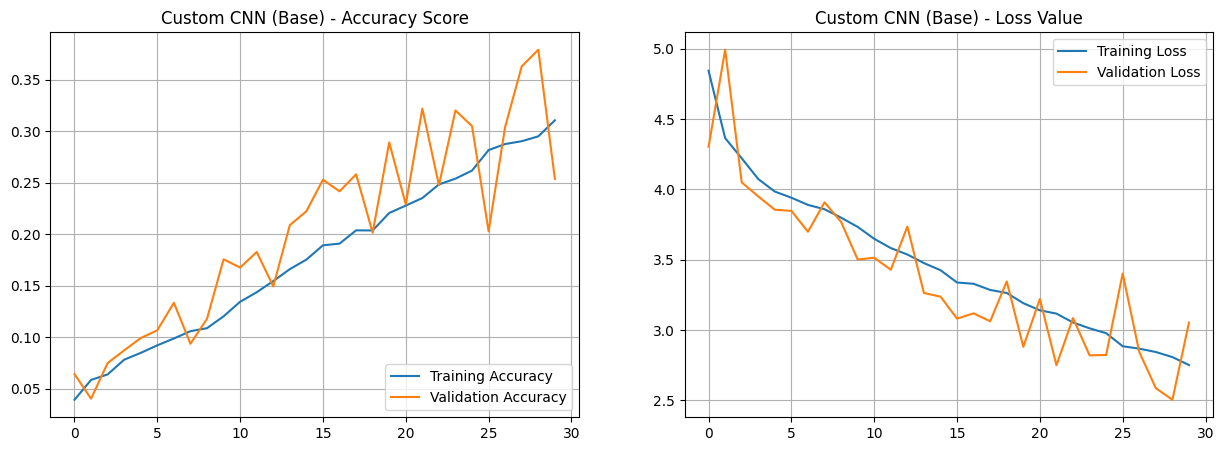


[INFO] Melakukan prediksi pada Data Test dengan Custom CNN (Base)...
186/186 ━━━━━━━━━━━━━━━━━━━━ 32s 169ms/step

--- Classification Report: Custom CNN (Base) ---
              precision    recall  f1-score   support

         A10       0.39      0.35      0.37       116
       A400M       0.48      0.39      0.43        80
       AG600       0.62      0.43      0.51        42
        AH64       0.34      0.50      0.41        80
      AKINCI       1.00      0.07      0.13        14
        AV8B       0.53      0.36      0.43        69
       An124       0.48      0.36      0.41        33
        An22       0.22      0.24      0.23        17
       An225       0.14      0.06      0.08        17
        An72       0.10      0.04      0.05        28
          B1       0.26      0.24      0.25        98
          B2       0.42      0.48      0.45        85
         B21       0.00      0.00      0.00         9
         B52       0.31      0.22      0.26        94
       Be200       0.63  

/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

[INFO] Confusion Matrix disimpan di: ../Images/Custom_CNN_(Base)_confusion_matrix.png


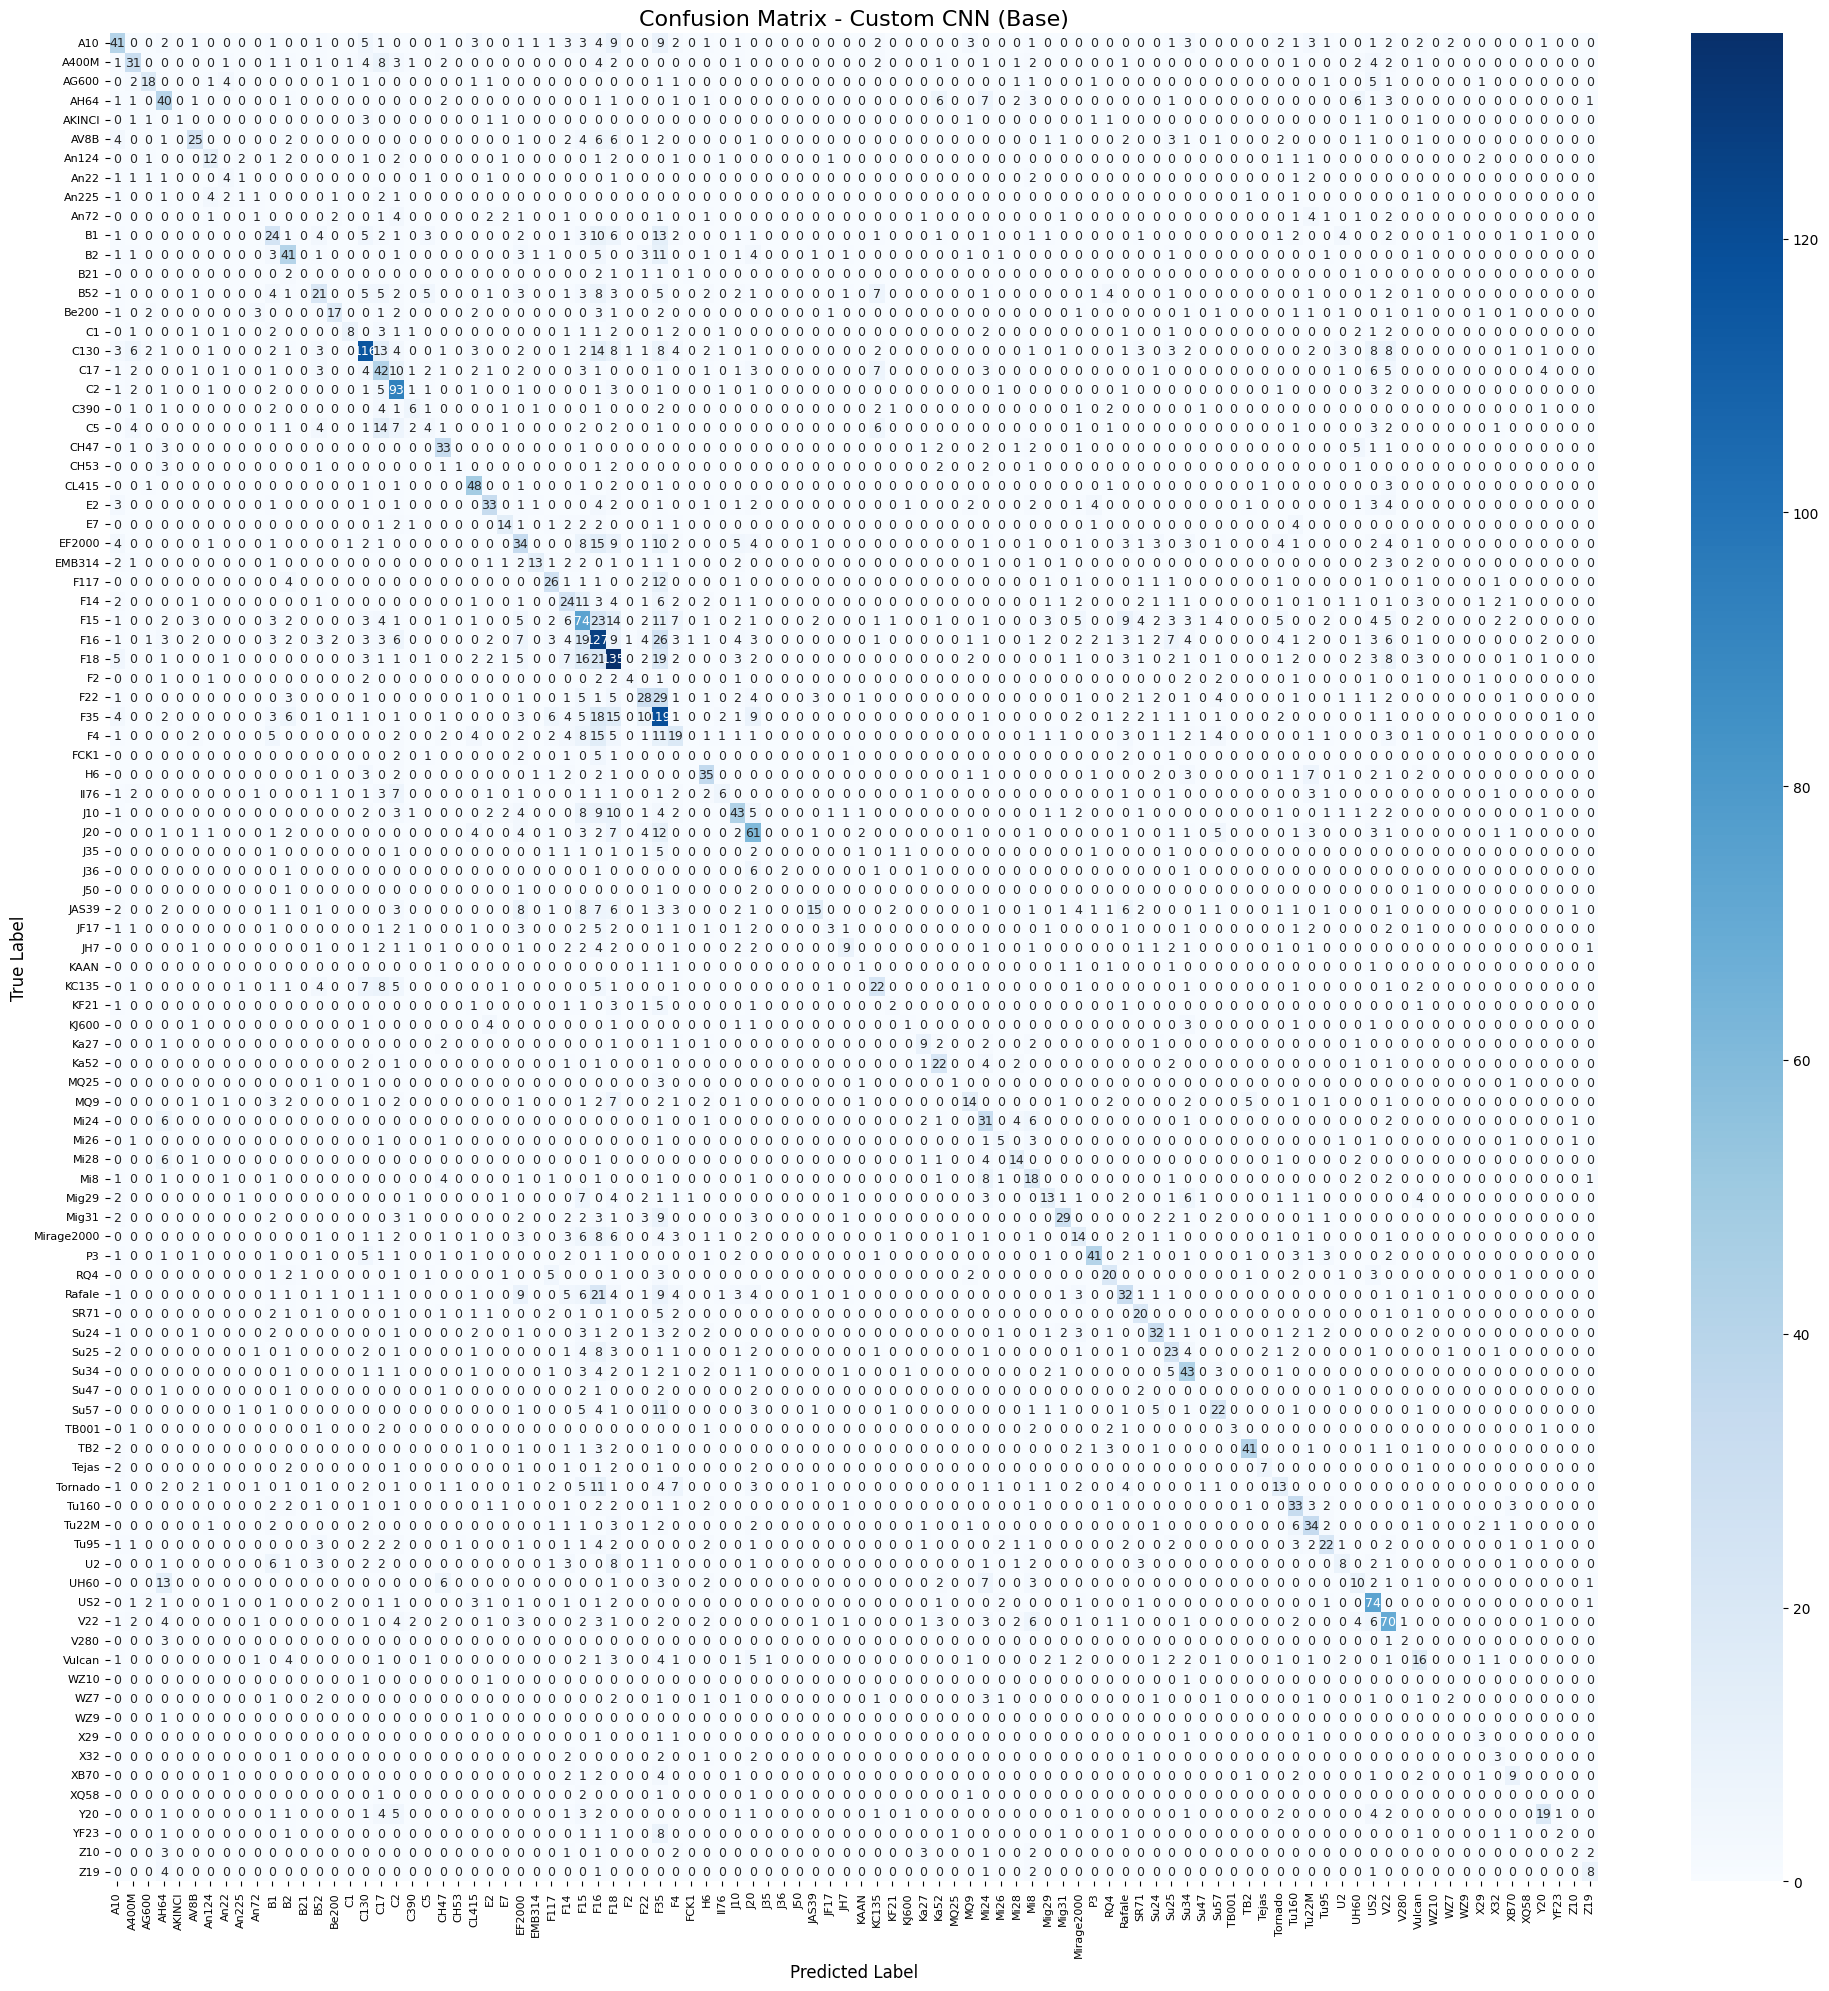

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_single_model_standalone(model, history, generator, model_name="Custom CNN"):
    """
    Fungsi evaluasi mandiri untuk satu model spesifik.
    Mencakup: 
    1. Grafik History (disimpan ke ../Images)
    2. Classification Report (disimpan sebagai CSV ke ../Reports)
    3. Confusion Matrix dengan anotasi nilai DAN Color Bar (disimpan ke ../Images)
    """
    
    image_dir = "../Images"
    report_dir = "../Reports"
    
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(report_dir, exist_ok=True)
    
    print(f"=== Memulai Evaluasi Mandiri: {model_name} ===")
    
    # VISUALISASI HISTORY TRAINING (Loss & Accuracy)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Accuracy Score')
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss Value')
    plt.grid(True)
    
    history_filename = f"{model_name.replace(' ', '_')}_history.png"
    plt.savefig(os.path.join(image_dir, history_filename), bbox_inches='tight')
    print(f"[INFO] Grafik History disimpan di: {os.path.join(image_dir, history_filename)}")
    plt.show()
    
    # PREDIKSI & CLASSIFICATION REPORT
    print(f"\n[INFO] Melakukan prediksi pada Data Test dengan {model_name}...")
    
    generator.reset()
    predictions = model.predict(generator, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    class_labels = list(generator.class_indices.keys())
    
    print(f"\n--- Classification Report: {model_name} ---")
    report_dict = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    
    print(classification_report(y_true, y_pred, target_names=class_labels))
    
    report_df = pd.DataFrame(report_dict).transpose()
    report_filename = f"{model_name.replace(' ', '_')}_report.csv"
    report_df.to_csv(os.path.join(report_dir, report_filename))
    print(f"[INFO] Classification Report (CSV) disimpan di: {os.path.join(report_dir, report_filename)}")
    
    # CONFUSION MATRIX ---
    print(f"\n--- Confusion Matrix: {model_name} ---")
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(24, 24)) 
    
    sns.heatmap(cm, 
                annot=True,      
                fmt='d',          
                cmap='Blues',   
                xticklabels=class_labels, 
                yticklabels=class_labels,
                cbar=True,       
                annot_kws={"size": 9}) 
                
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    
    # Simpan Gambar Confusion Matrix
    cm_filename = f"{model_name.replace(' ', '_')}_confusion_matrix.png"
    plt.savefig(os.path.join(image_dir, cm_filename), bbox_inches='tight')
    print(f"[INFO] Confusion Matrix disimpan di: {os.path.join(image_dir, cm_filename)}")
    
    plt.show()

# --- EKSEKUSI EVALUASI UNTUK MODEL 1 ---
evaluate_single_model_standalone(model_base, history_base, test_generator, model_name="Custom CNN (Base)")

## Model 2 - Pretrained MobileNetV2 (Fine-Tuning)

In [9]:
def build_mobilenet_transfer(input_shape, num_classes):
    """
    Implementasi Transfer Learning menggunakan MobileNetV2.
    Tahap 1: Feature Extraction (Base Frozen).
    """
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model
    base_model.trainable = False
    
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, base_model

model_mobile, base_mobile = build_mobilenet_transfer((IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES)

print("Training Head Model 2 (MobileNetV2)...")
history_mobile_1 = model_mobile.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[ReduceLROnPlateau(factor=0.2, patience=2)]
)

"""
Fine Tuning Phase:
Mengaktifkan kembali (Unfreeze) 30 layer terakhir untuk penyesuaian bobot spesifik pada dataset pesawat.
"""
base_mobile.trainable = True
fine_tune_at = len(base_mobile.layers) - 30
for layer in base_mobile.layers[:fine_tune_at]:
    layer.trainable = False

model_mobile.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

print("Fine-Tuning Model 2 (MobileNetV2)...")
history_mobile_2 = model_mobile.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)
model_mobile.save('../Models/model_mobilenetv2_finetuned.h5')

Training Head Model 2 (MobileNetV2)...
Epoch 1/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.0707 - loss: 4.1913

2025-12-18 19:34:09.356914: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 12 bytes spill stores, 12 bytes spill loads

2025-12-18 19:34:09.525927: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195_0', 184 bytes spill stores, 520 bytes spill loads

2025-12-18 19:34:09.610419: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 112 bytes spill stores, 112 bytes spill loads

2025-12-18 19:34:09.845061: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 8 bytes spill stores, 8 bytes spill loads

2025-12-18 19:34:09.990920: I extern

892/892 ━━━━━━━━━━━━━━━━━━━━ 313s 345ms/step - accuracy: 0.0707 - loss: 4.1910 - val_accuracy: 0.1810 - val_loss: 3.4723 - learning_rate: 0.0010
Epoch 2/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 296s 332ms/step - accuracy: 0.1446 - loss: 3.6021 - val_accuracy: 0.2221 - val_loss: 3.2045 - learning_rate: 0.0010
Epoch 3/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 396s 444ms/step - accuracy: 0.1705 - loss: 3.4123 - val_accuracy: 0.2541 - val_loss: 3.0732 - learning_rate: 0.0010
Epoch 4/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 323s 362ms/step - accuracy: 0.1921 - loss: 3.3075 - val_accuracy: 0.2600 - val_loss: 2.9582 - learning_rate: 0.0010
Epoch 5/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 350s 393ms/step - accuracy: 0.1993 - loss: 3.2370 - val_accuracy: 0.2706 - val_loss: 2.9151 - learning_rate: 0.0010
Epoch 6/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 289s 324ms/step - accuracy: 0.2064 - loss: 3.2039 - val_accuracy: 0.2914 - val_loss: 2.8467 - learning_rate: 0.0010
Epoch 7/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 275s 308ms/step - accuracy: 0.2237 

2025-12-18 20:20:28.552905: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6521', 4 bytes spill stores, 4 bytes spill loads



892/892 ━━━━━━━━━━━━━━━━━━━━ 294s 318ms/step - accuracy: 0.1806 - loss: 3.4107 - val_accuracy: 0.3121 - val_loss: 2.7656 - learning_rate: 1.0000e-05
Epoch 2/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 284s 318ms/step - accuracy: 0.2287 - loss: 3.1109 - val_accuracy: 0.3224 - val_loss: 2.6949 - learning_rate: 1.0000e-05
Epoch 3/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 276s 309ms/step - accuracy: 0.2435 - loss: 3.0072 - val_accuracy: 0.3313 - val_loss: 2.6367 - learning_rate: 1.0000e-05
Epoch 4/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 286s 321ms/step - accuracy: 0.2603 - loss: 2.9171 - val_accuracy: 0.3433 - val_loss: 2.5873 - learning_rate: 1.0000e-05
Epoch 5/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 286s 320ms/step - accuracy: 0.2690 - loss: 2.8780 - val_accuracy: 0.3596 - val_loss: 2.5261 - learning_rate: 1.0000e-05
Epoch 6/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 336s 376ms/step - accuracy: 0.2780 - loss: 2.8129 - val_accuracy: 0.3725 - val_loss: 2.4742 - learning_rate: 1.0000e-05
Epoch 7/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 391s 439ms/

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_single_model_standalone_v2(model, history, generator, model_name):
    """
    Fungsi evaluasi mandiri (Dengan Fitur Save Report & Images).
    Khusus untuk Model 2 & 3.
    """
    
    image_dir = "../Images"
    report_dir = "../Reports"
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(report_dir, exist_ok=True)
    
    print(f"=== Memulai Evaluasi Mandiri: {model_name} ===")
    
    # VISUALISASI HISTORY
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Accuracy Score')
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss Value')
    plt.grid(True)
    
    history_filename = f"{model_name.replace(' ', '_').replace('(', '').replace(')', '')}_history.png"
    plt.savefig(os.path.join(image_dir, history_filename), bbox_inches='tight')
    print(f"[INFO] Grafik History disimpan di: {os.path.join(image_dir, history_filename)}")
    plt.show()
    
    # PREDIKSI
    print(f"\n[INFO] Melakukan prediksi pada Data Test dengan {model_name}...")
    generator.reset()
    predictions = model.predict(generator, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    class_labels = list(generator.class_indices.keys())
    
    # CLASSIFICATION REPORT (CSV)
    print(f"\n--- Classification Report: {model_name} ---")
    
    report_dict = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    report_filename = f"{model_name.replace(' ', '_').replace('(', '').replace(')', '')}_report.csv"
    report_df.to_csv(os.path.join(report_dir, report_filename))
    
    print(classification_report(y_true, y_pred, target_names=class_labels))
    print(f"[INFO] Classification Report (CSV) disimpan di: {os.path.join(report_dir, report_filename)}")
    
    # CONFUSION MATRIX
    print(f"\n--- Confusion Matrix: {model_name} ---")
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(24, 24))
    sns.heatmap(cm, 
                annot=True,         
                fmt='d', 
                cmap='Greens',      
                xticklabels=class_labels, 
                yticklabels=class_labels,
                cbar=True,         
                annot_kws={"size": 9})
                
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    
    cm_filename = f"{model_name.replace(' ', '_').replace('(', '').replace(')', '')}_confusion_matrix.png"
    plt.savefig(os.path.join(image_dir, cm_filename), bbox_inches='tight')
    print(f"[INFO] Confusion Matrix disimpan di: {os.path.join(image_dir, cm_filename)}")
    
    plt.show()

Processing Evaluation for Model 2
=== Memulai Evaluasi Mandiri: MobileNetV2 (Fine-Tuned) ===
[INFO] Grafik History disimpan di: ../Images/MobileNetV2_Fine-Tuned_history.png


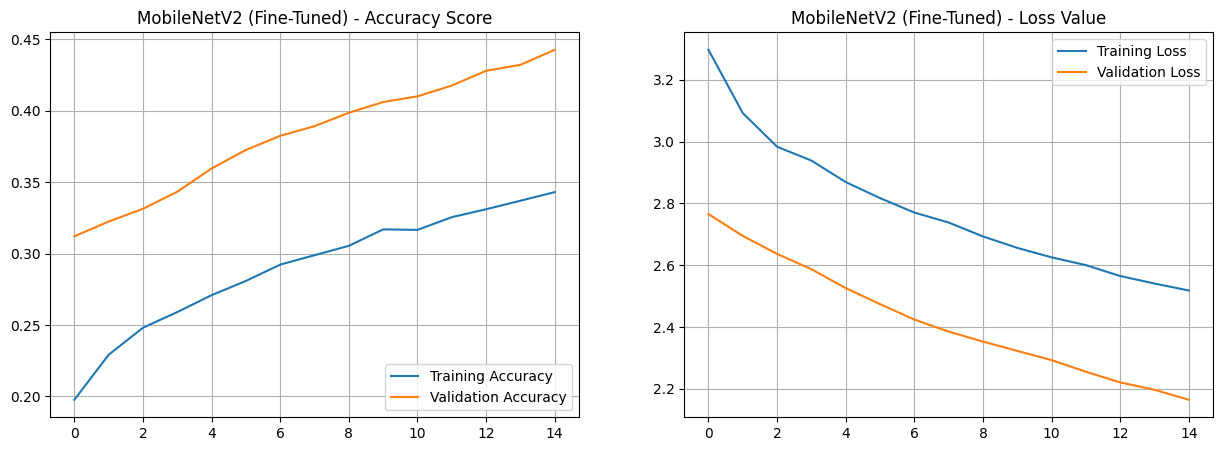


[INFO] Melakukan prediksi pada Data Test dengan MobileNetV2 (Fine-Tuned)...
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step

2025-12-18 21:36:38.155933: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1152', 8 bytes spill stores, 8 bytes spill loads

2025-12-18 21:36:38.165881: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1152', 12 bytes spill stores, 12 bytes spill loads

2025-12-18 21:36:38.290613: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1152_0', 184 bytes spill stores, 520 bytes spill loads

2025-12-18 21:36:38.559002: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1152', 112 bytes spill stores, 112 bytes spill loads

2025-12-18 21:36:38.559552: I extern

186/186 ━━━━━━━━━━━━━━━━━━━━ 85s 440ms/step

--- Classification Report: MobileNetV2 (Fine-Tuned) ---
              precision    recall  f1-score   support

         A10       0.43      0.54      0.48       116
       A400M       0.67      0.39      0.49        80
       AG600       0.56      0.55      0.55        42
        AH64       0.46      0.80      0.58        80
      AKINCI       0.75      0.21      0.33        14
        AV8B       0.74      0.49      0.59        69
       An124       0.50      0.30      0.38        33
        An22       0.50      0.06      0.11        17
       An225       0.33      0.06      0.10        17
        An72       0.67      0.07      0.13        28
          B1       0.48      0.49      0.48        98
          B2       0.39      0.79      0.52        85
         B21       1.00      0.11      0.20         9
         B52       0.42      0.54      0.47        94
       Be200       0.39      0.29      0.33        45
          C1       0.53      0.22 

/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

[INFO] Confusion Matrix disimpan di: ../Images/MobileNetV2_Fine-Tuned_confusion_matrix.png


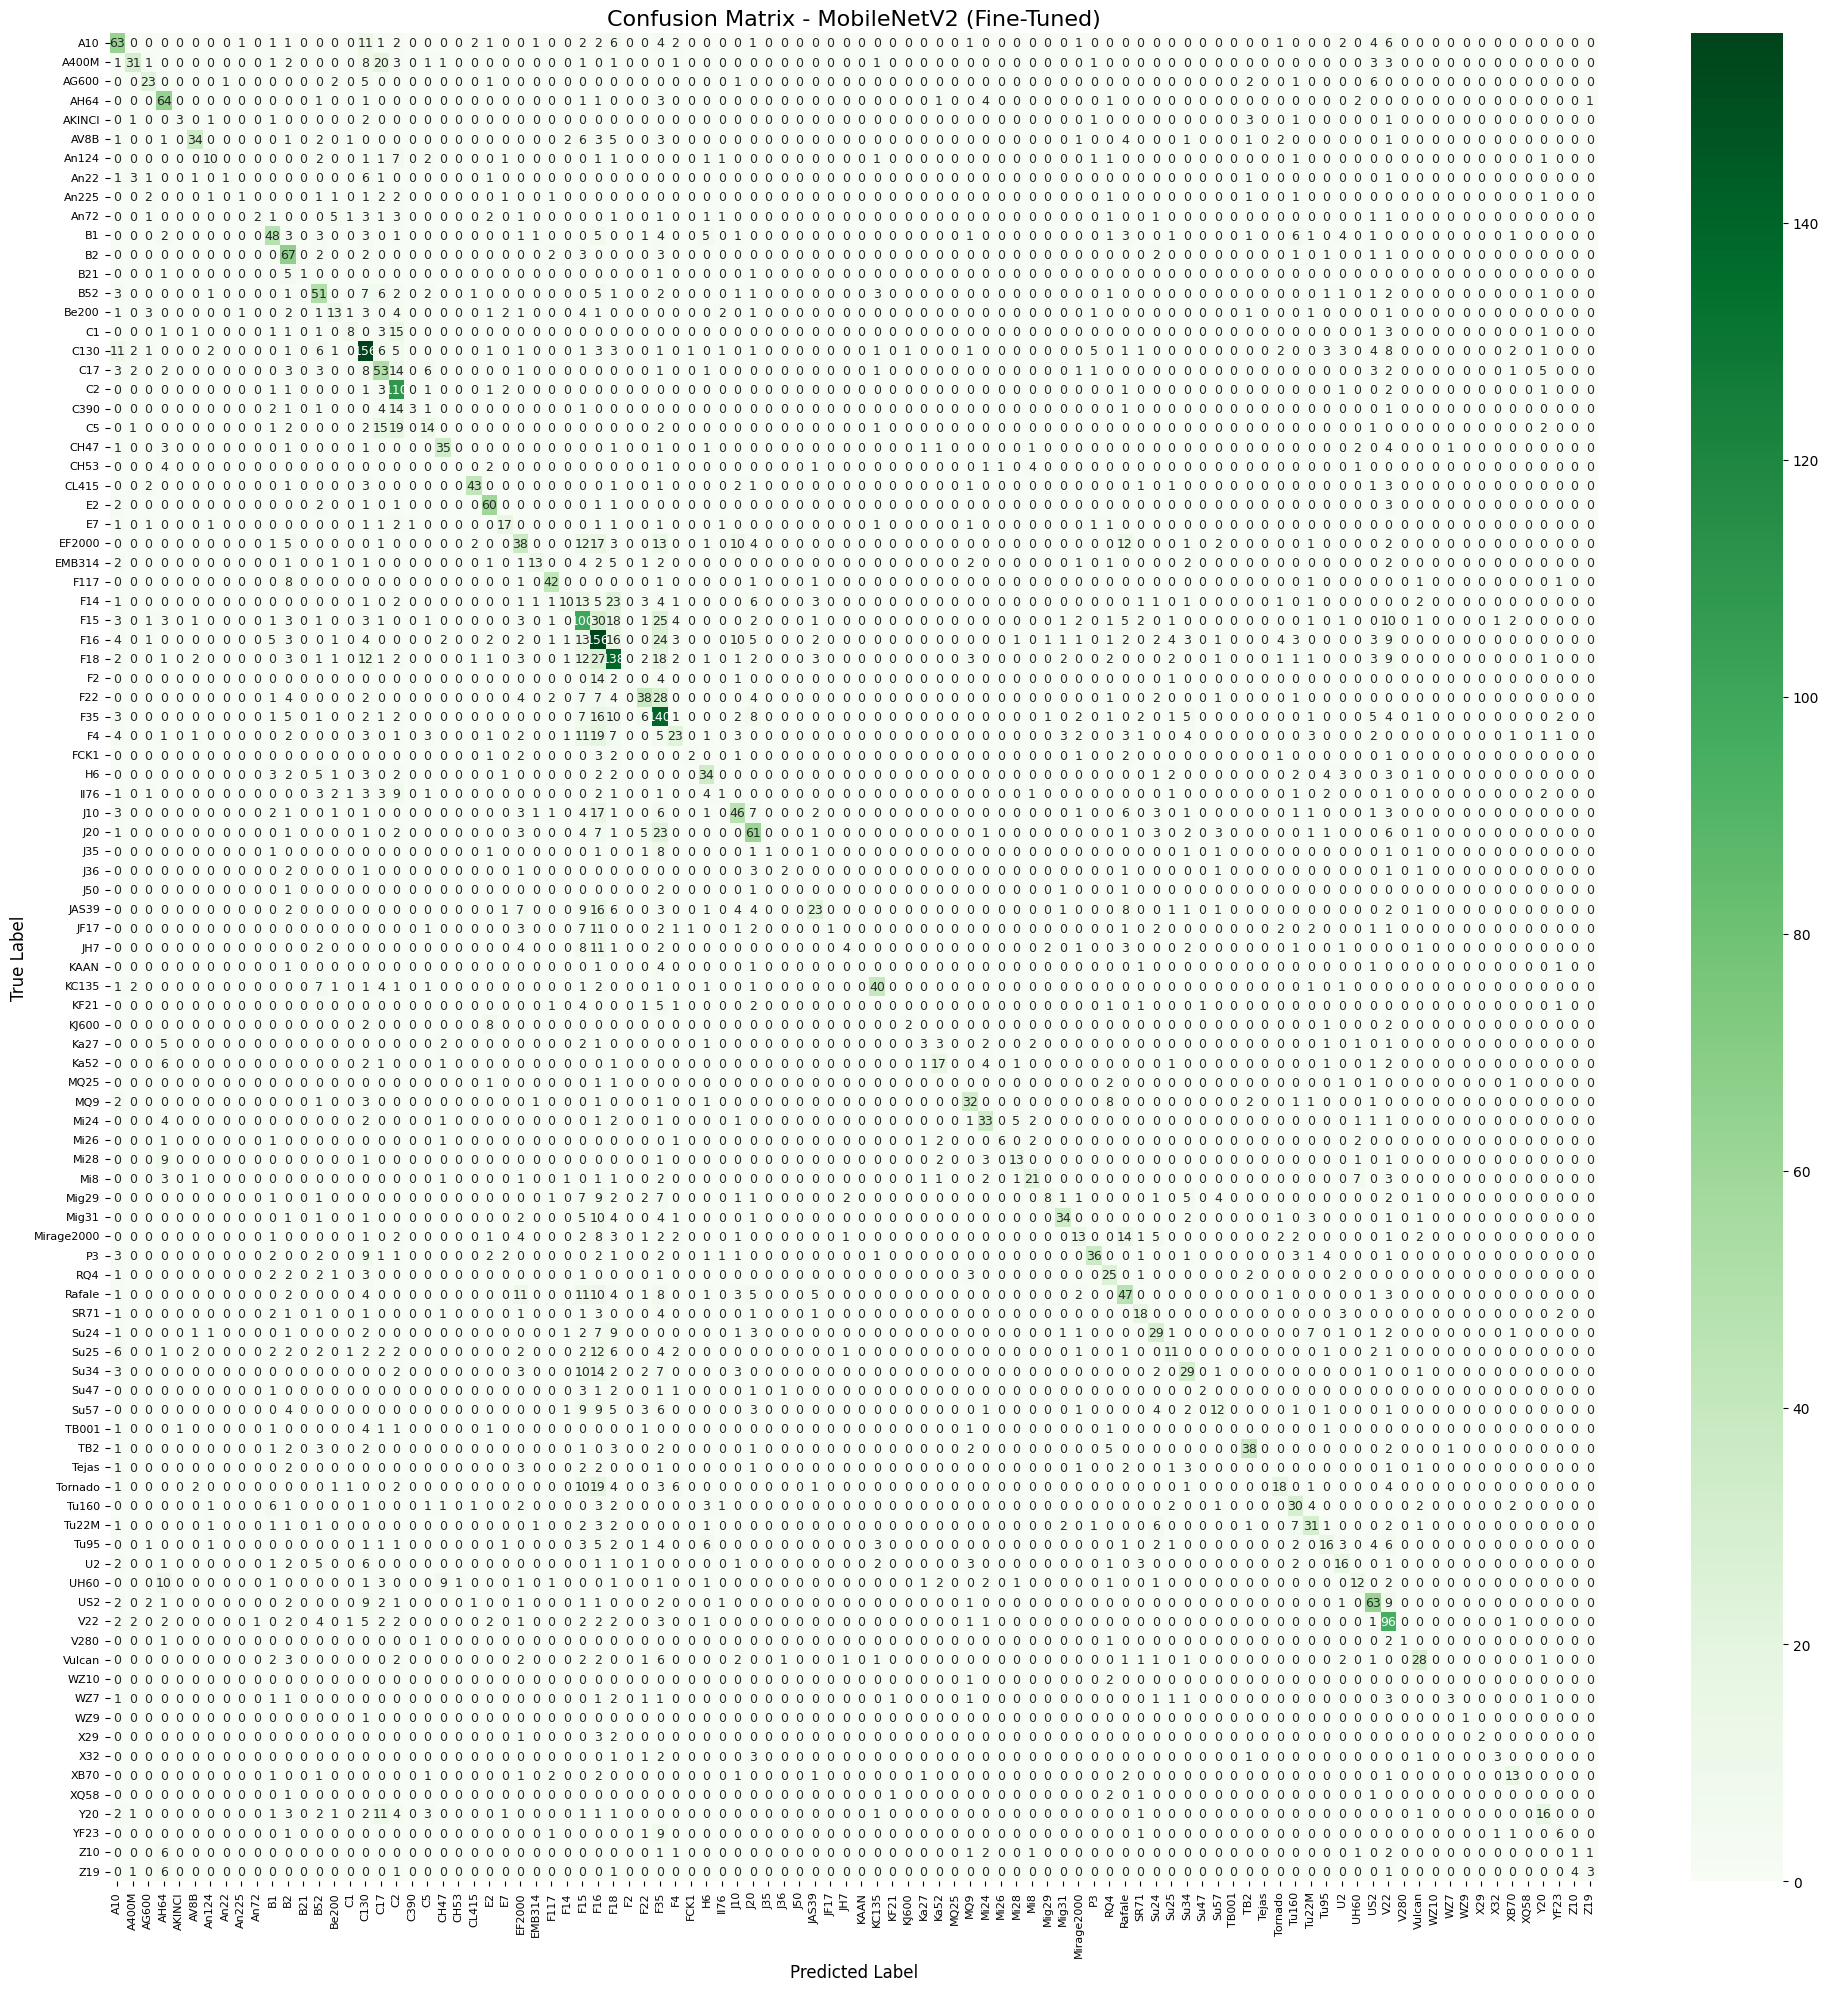

In [11]:
print("Processing Evaluation for Model 2")
evaluate_single_model_standalone_v2(model_mobile, history_mobile_2, test_generator, model_name="MobileNetV2 (Fine-Tuned)")

## Model 3 - Pretrained EfficientNetB0 (Fine-Tuning)

In [12]:
def build_efficientnet_transfer(input_shape, num_classes):
    """
    Implementasi Transfer Learning menggunakan EfficientNetB0.
    Model ini dipilih karena keseimbangan yang superior antara akurasi dan kompleksitas.
    """
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    base_model.trainable = False
    
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, base_model

model_efficient, base_efficient = build_efficientnet_transfer((IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES)

print("Training Head Model 3 (EfficientNetB0)...")
history_eff_1 = model_efficient.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[ReduceLROnPlateau(factor=0.2, patience=2)]
)

# Fine Tuning Phase
base_efficient.trainable = True
fine_tune_at = len(base_efficient.layers) - 40
for layer in base_efficient.layers[:fine_tune_at]:
    layer.trainable = False

model_efficient.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

print("Fine-Tuning Model 3 (EfficientNetB0)...")
history_eff_2 = model_efficient.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)
model_efficient.save('../Models/model_efficientnet_finetuned.h5')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 81s 5us/step
Training Head Model 3 (EfficientNetB0)...
Epoch 1/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.0342 - loss: 4.6753

2025-12-18 21:43:35.842979: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2098_0', 48 bytes spill stores, 48 bytes spill loads

2025-12-18 21:43:36.040634: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2098', 484 bytes spill stores, 484 bytes spill loads

2025-12-18 21:44:03.612312: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2098', 64 bytes spill stores, 64 bytes spill loads



892/892 ━━━━━━━━━━━━━━━━━━━━ 323s 346ms/step - accuracy: 0.0342 - loss: 4.6751 - val_accuracy: 0.0445 - val_loss: 4.4269 - learning_rate: 0.0010
Epoch 2/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 292s 327ms/step - accuracy: 0.0433 - loss: 4.3042 - val_accuracy: 0.0491 - val_loss: 4.2640 - learning_rate: 0.0010
Epoch 3/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 473s 531ms/step - accuracy: 0.0467 - loss: 4.2705 - val_accuracy: 0.0491 - val_loss: 4.2532 - learning_rate: 0.0010
Epoch 4/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 306s 344ms/step - accuracy: 0.0490 - loss: 4.2611 - val_accuracy: 0.0445 - val_loss: 4.2554 - learning_rate: 0.0010
Epoch 5/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 282s 316ms/step - accuracy: 0.0439 - loss: 4.2660 - val_accuracy: 0.0491 - val_loss: 4.2323 - learning_rate: 0.0010
Epoch 6/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 322s 362ms/step - accuracy: 0.0486 - loss: 4.2496 - val_accuracy: 0.0491 - val_loss: 4.2422 - learning_rate: 0.0010
Epoch 7/10
892/892 ━━━━━━━━━━━━━━━━━━━━ 297s 332ms/step - accuracy: 0.0483 

2025-12-18 22:32:07.637398: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-18 22:32:07.832853: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


892/892 ━━━━━━━━━━━━━━━━━━━━ 340s 356ms/step - accuracy: 0.0471 - loss: 4.2736 - val_accuracy: 0.0491 - val_loss: 4.2271 - learning_rate: 1.0000e-05
Epoch 2/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 301s 337ms/step - accuracy: 0.0474 - loss: 4.2406 - val_accuracy: 0.0491 - val_loss: 4.2357 - learning_rate: 1.0000e-05
Epoch 3/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 293s 329ms/step - accuracy: 0.0480 - loss: 4.2391 - val_accuracy: 0.0491 - val_loss: 4.2403 - learning_rate: 1.0000e-05
Epoch 4/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 378s 424ms/step - accuracy: 0.0507 - loss: 4.2299 - val_accuracy: 0.0491 - val_loss: 4.2440 - learning_rate: 1.0000e-05
Epoch 5/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 335s 375ms/step - accuracy: 0.0512 - loss: 4.2205 - val_accuracy: 0.0491 - val_loss: 4.2266 - learning_rate: 5.0000e-06
Epoch 6/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 287s 321ms/step - accuracy: 0.0493 - loss: 4.2396 - val_accuracy: 0.0491 - val_loss: 4.2412 - learning_rate: 5.0000e-06
Epoch 7/15
892/892 ━━━━━━━━━━━━━━━━━━━━ 283s 317ms/

Processing Evaluation for Model 3
=== Memulai Evaluasi Mandiri: EfficientNetB0 (Fine-Tuned) ===
[INFO] Grafik History disimpan di: ../Images/EfficientNetB0_(Fine-Tuned)_history.png


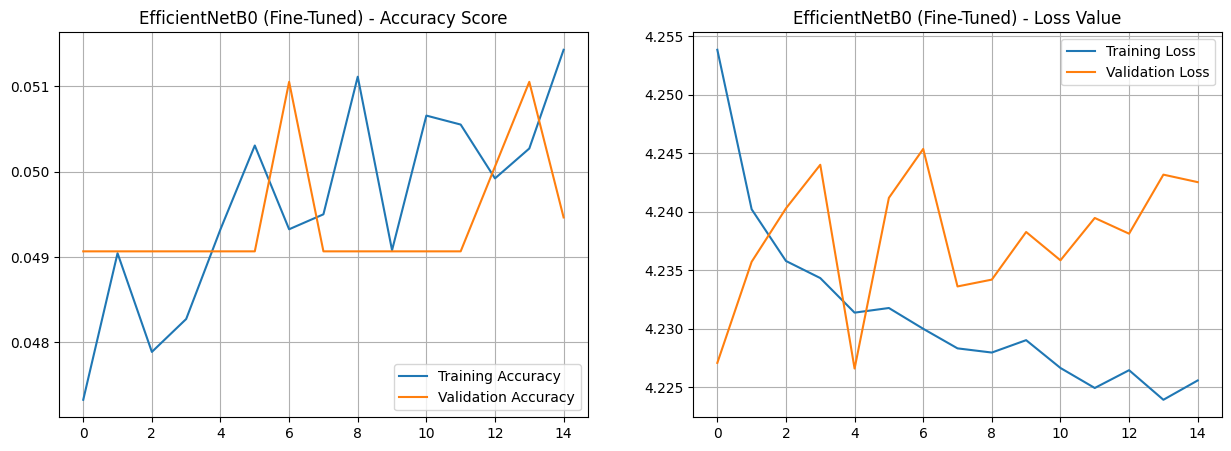


[INFO] Melakukan prediksi pada Data Test dengan EfficientNetB0 (Fine-Tuned)...
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step

2025-12-18 23:54:06.859928: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2055', 64 bytes spill stores, 64 bytes spill loads



186/186 ━━━━━━━━━━━━━━━━━━━━ 81s 408ms/step

--- Classification Report: EfficientNetB0 (Fine-Tuned) ---
              precision    recall  f1-score   support

         A10       0.00      0.00      0.00       116
       A400M       0.00      0.00      0.00        80
       AG600       0.00      0.00      0.00        42
        AH64       0.00      0.00      0.00        80
      AKINCI       0.00      0.00      0.00        14
        AV8B       0.00      0.00      0.00        69
       An124       0.00      0.00      0.00        33
        An22       0.00      0.00      0.00        17
       An225       0.00      0.00      0.00        17
        An72       0.00      0.00      0.00        28
          B1       0.00      0.00      0.00        98
          B2       0.00      0.00      0.00        85
         B21       0.00      0.00      0.00         9
         B52       0.00      0.00      0.00        94
       Be200       0.00      0.00      0.00        45
          C1       0.00      0.

/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

[INFO] Confusion Matrix disimpan di: ../Images/EfficientNetB0_(Fine-Tuned)_confusion_matrix.png


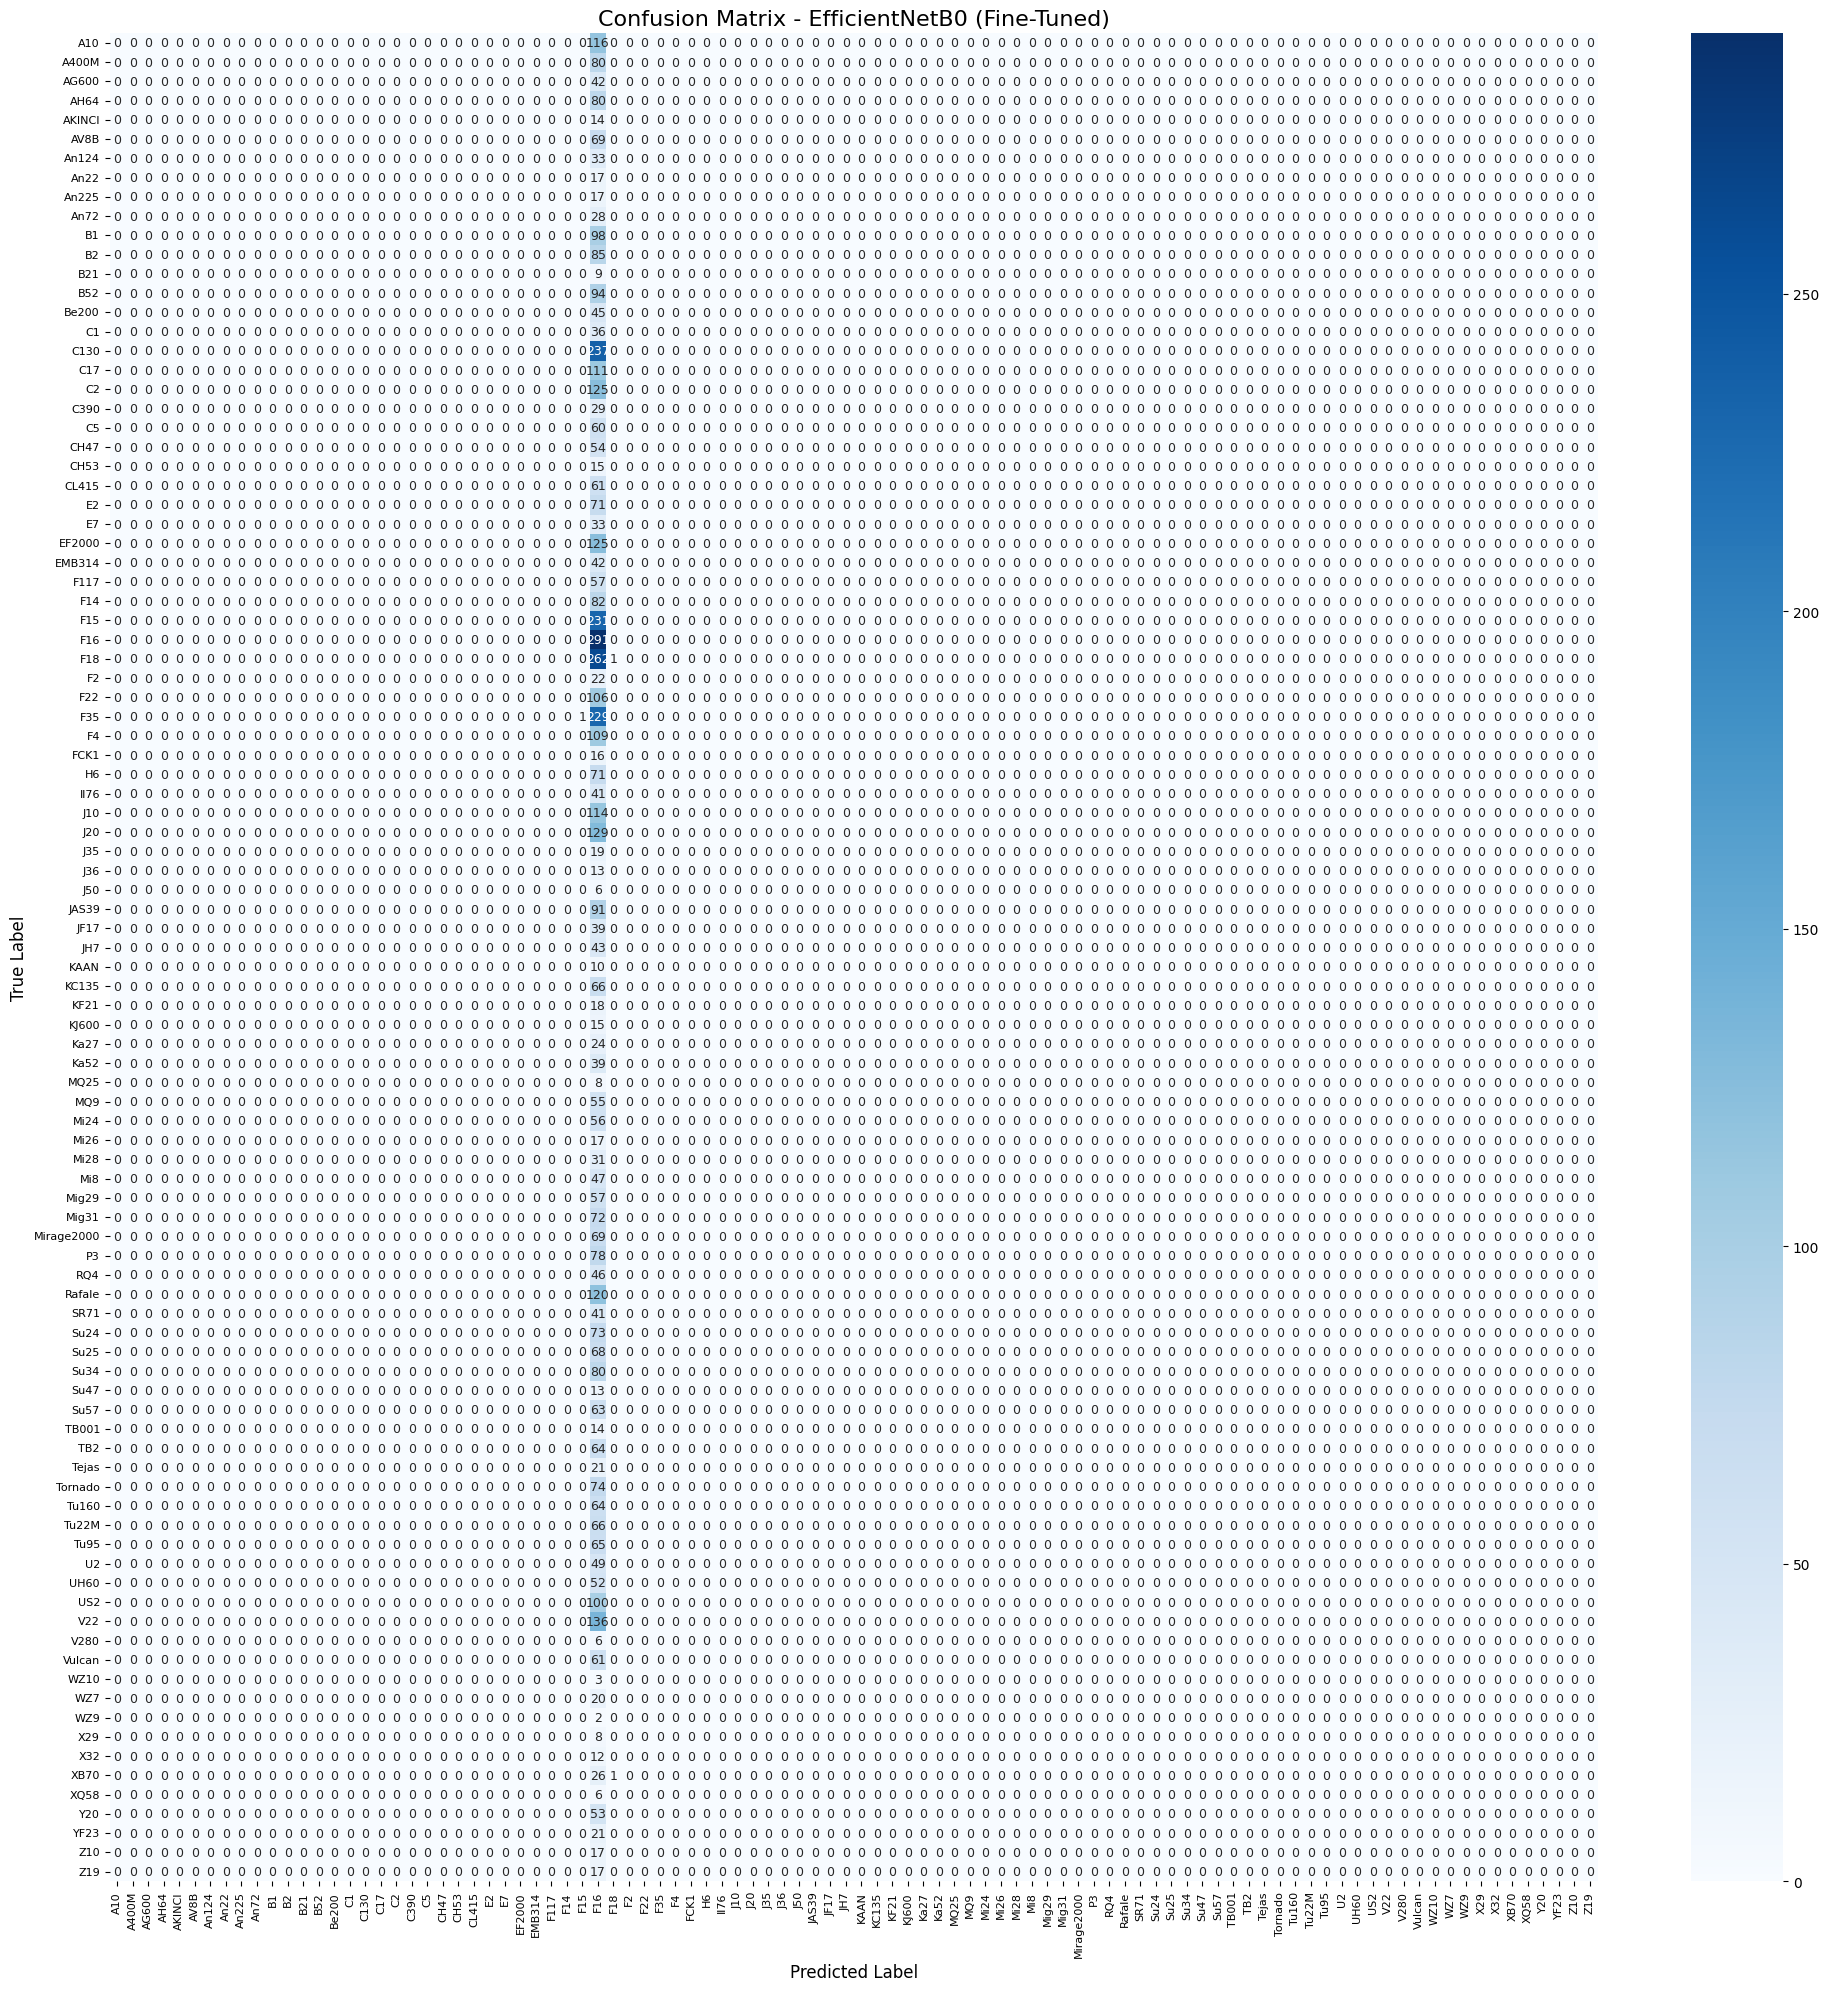

In [13]:
print("Processing Evaluation for Model 3")
evaluate_single_model_standalone(model_efficient, history_eff_2, test_generator, model_name="EfficientNetB0 (Fine-Tuned)")

## Evaluasi & Perbandingan

Processing: Custom CNN

--- Evaluasi Custom CNN ---
186/186 ━━━━━━━━━━━━━━━━━━━━ 32s 168ms/step
              precision    recall  f1-score   support

         A10       0.39      0.35      0.37       116
       A400M       0.48      0.39      0.43        80
       AG600       0.62      0.43      0.51        42
        AH64       0.34      0.50      0.41        80
      AKINCI       1.00      0.07      0.13        14
        AV8B       0.53      0.36      0.43        69
       An124       0.48      0.36      0.41        33
        An22       0.22      0.24      0.23        17
       An225       0.14      0.06      0.08        17
        An72       0.10      0.04      0.05        28
          B1       0.26      0.24      0.25        98
          B2       0.42      0.48      0.45        85
         B21       0.00      0.00      0.00         9
         B52       0.31      0.22      0.26        94
       Be200       0.63      0.38      0.47        45
          C1       0.73      0.22      

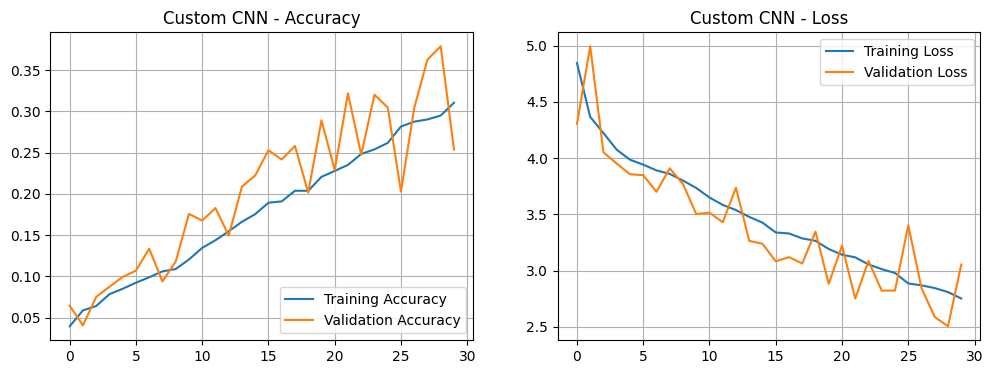

Processing: MobileNetV2

--- Evaluasi MobileNetV2 (TL) ---
186/186 ━━━━━━━━━━━━━━━━━━━━ 31s 166ms/step
              precision    recall  f1-score   support

         A10       0.43      0.54      0.48       116
       A400M       0.67      0.39      0.49        80
       AG600       0.56      0.55      0.55        42
        AH64       0.46      0.80      0.58        80
      AKINCI       0.75      0.21      0.33        14
        AV8B       0.74      0.49      0.59        69
       An124       0.50      0.30      0.38        33
        An22       0.50      0.06      0.11        17
       An225       0.33      0.06      0.10        17
        An72       0.67      0.07      0.13        28
          B1       0.48      0.49      0.48        98
          B2       0.39      0.79      0.52        85
         B21       1.00      0.11      0.20         9
         B52       0.42      0.54      0.47        94
       Be200       0.39      0.29      0.33        45
          C1       0.53      0.2

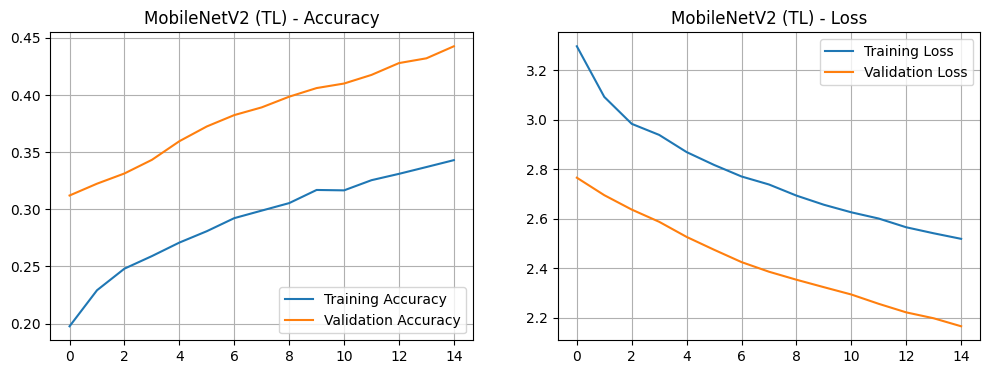

Processing: EfficientNetB0...

--- Evaluasi EfficientNetB0 (TL) ---
186/186 ━━━━━━━━━━━━━━━━━━━━ 33s 175ms/step
              precision    recall  f1-score   support

         A10       0.00      0.00      0.00       116
       A400M       0.00      0.00      0.00        80
       AG600       0.00      0.00      0.00        42
        AH64       0.00      0.00      0.00        80
      AKINCI       0.00      0.00      0.00        14
        AV8B       0.00      0.00      0.00        69
       An124       0.00      0.00      0.00        33
        An22       0.00      0.00      0.00        17
       An225       0.00      0.00      0.00        17
        An72       0.00      0.00      0.00        28
          B1       0.00      0.00      0.00        98
          B2       0.00      0.00      0.00        85
         B21       0.00      0.00      0.00         9
         B52       0.00      0.00      0.00        94
       Be200       0.00      0.00      0.00        45
          C1       0.00

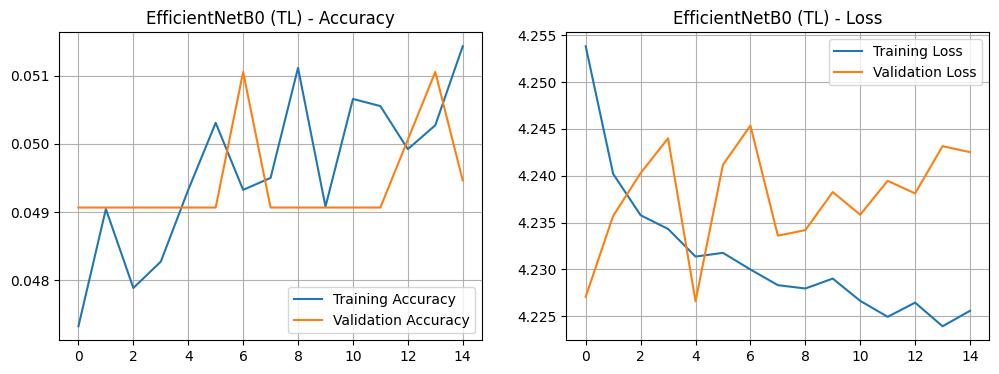


=== Tabel Perbandingan Akhir ===
                 Model  Accuracy  F1-Score (Macro)  F1-Score (Weighted)
0           Custom CNN  0.381901          0.316755             0.371429
1     MobileNetV2 (TL)  0.440993          0.352793             0.420331
2  EfficientNetB0 (TL)  0.049299          0.001055             0.004939
[INFO] Tabel Perbandingan disimpan di: ../Reports/Final_Model_Comparison.csv
[INFO] Grafik Perbandingan disimpan di: ../Images/Final_Model_Comparison_Chart.png


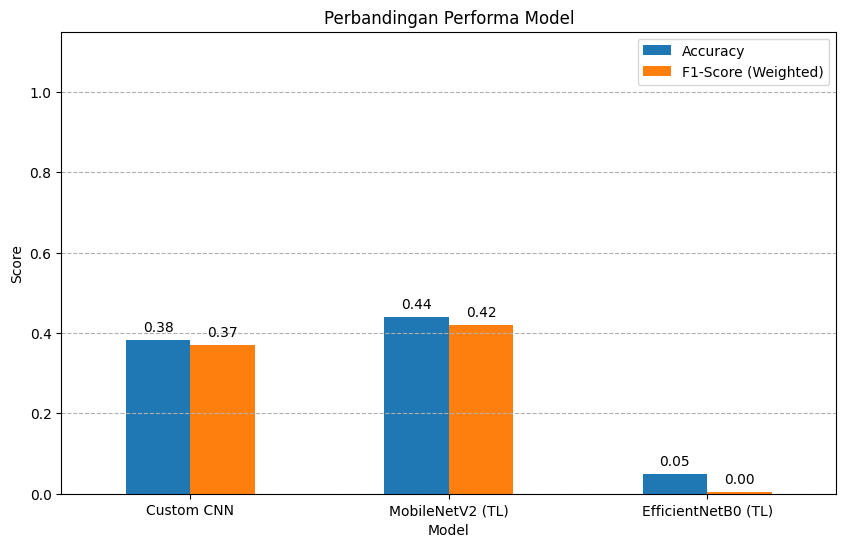

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.metrics import classification_report

# KONFIGURASI PATH PENYIMPANAN
image_dir = "../Images"
report_dir = "../Reports"
os.makedirs(image_dir, exist_ok=True)
os.makedirs(report_dir, exist_ok=True)

def evaluate_model(model, generator, model_name):
    """
    Menghasilkan laporan evaluasi:
    1. Print Classification Report (dengan penanganan zero_division).
    2. Simpan Classification Report ke CSV.
    3. Return metrics untuk tabel perbandingan.
    """
    print(f"\n--- Evaluasi {model_name} ---")
    
    generator.reset()
    predictions = model.predict(generator, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    class_labels = list(generator.class_indices.keys())
    
    print(classification_report(y_true, y_pred, target_names=class_labels, zero_division=0))
    
    report_dict = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).transpose()
    
    safe_name = model_name.replace(' ', '_').replace('(', '').replace(')', '')
    csv_filename = f"Summary_{safe_name}_report.csv"
    report_df.to_csv(os.path.join(report_dir, csv_filename))
    print(f"[INFO] Report disimpan di: {os.path.join(report_dir, csv_filename)}")
    
    return report_dict['accuracy'], report_dict['macro avg']['f1-score'], report_dict['weighted avg']['f1-score']

def plot_history(history, title):
    """
    Memvisualisasikan DAN MENYIMPAN grafik Loss/Accuracy.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')
    plt.grid(True)
    
    safe_title = title.replace(' ', '_').replace('(', '').replace(')', '')
    filename = f"Summary_{safe_title}_history.png"
    plt.savefig(os.path.join(image_dir, filename), bbox_inches='tight')
    print(f"[INFO] Grafik disimpan di: {os.path.join(image_dir, filename)}")
    
    plt.show()

# EKSEKUSI EVALUASI BERGILIR

# Evaluasi Model Base (Custom CNN)
print("Processing: Custom CNN")
acc_base, f1_macro_base, f1_weighted_base = evaluate_model(model_base, test_generator, "Custom CNN")
plot_history(history_base, "Custom CNN")

# Evaluasi Model MobileNet
print("Processing: MobileNetV2")
acc_mobile, f1_macro_mobile, f1_weighted_mobile = evaluate_model(model_mobile, test_generator, "MobileNetV2 (TL)")
plot_history(history_mobile_2, "MobileNetV2 (TL)") 

# Evaluasi Model EfficientNet
print("Processing: EfficientNetB0...")
acc_eff, f1_macro_eff, f1_weighted_eff = evaluate_model(model_efficient, test_generator, "EfficientNetB0 (TL)")
plot_history(history_eff_2, "EfficientNetB0 (TL)")

# TABEL PERBANDINGAN AKHIR
comparison_df = pd.DataFrame({
    'Model': ['Custom CNN', 'MobileNetV2 (TL)', 'EfficientNetB0 (TL)'],
    'Accuracy': [acc_base, acc_mobile, acc_eff],
    'F1-Score (Macro)': [f1_macro_base, f1_macro_mobile, f1_macro_eff],
    'F1-Score (Weighted)': [f1_weighted_base, f1_weighted_mobile, f1_weighted_eff]
})

print("\n=== Tabel Perbandingan Akhir ===")
print(comparison_df)

comparison_csv_path = os.path.join(report_dir, "Final_Model_Comparison.csv")
comparison_df.to_csv(comparison_csv_path, index=False)
print(f"[INFO] Tabel Perbandingan disimpan di: {comparison_csv_path}")

# VISUALISASI PERBANDINGAN
ax = comparison_df.set_index('Model')[['Accuracy', 'F1-Score (Weighted)']].plot(kind='bar', figsize=(10, 6))
plt.title('Perbandingan Performa Model')
plt.ylabel('Score')
plt.ylim(0, 1.15) 
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')

plt.legend(loc='upper right')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

chart_filename = "Final_Model_Comparison_Chart.png"
plt.savefig(os.path.join(image_dir, chart_filename), bbox_inches='tight')
print(f"[INFO] Grafik Perbandingan disimpan di: {os.path.join(image_dir, chart_filename)}")

plt.show()

## Visualisasi Hasil Prediksi (Inference Visualization).

=== VISUALISASI GALERI PREDIKSI (BATCH) ===

[VISUALISASI] Membuat Galeri untuk Custom CNN
[INFO] Galeri Custom CNN disimpan di ../Images/Gallery_Custom_CNN.png


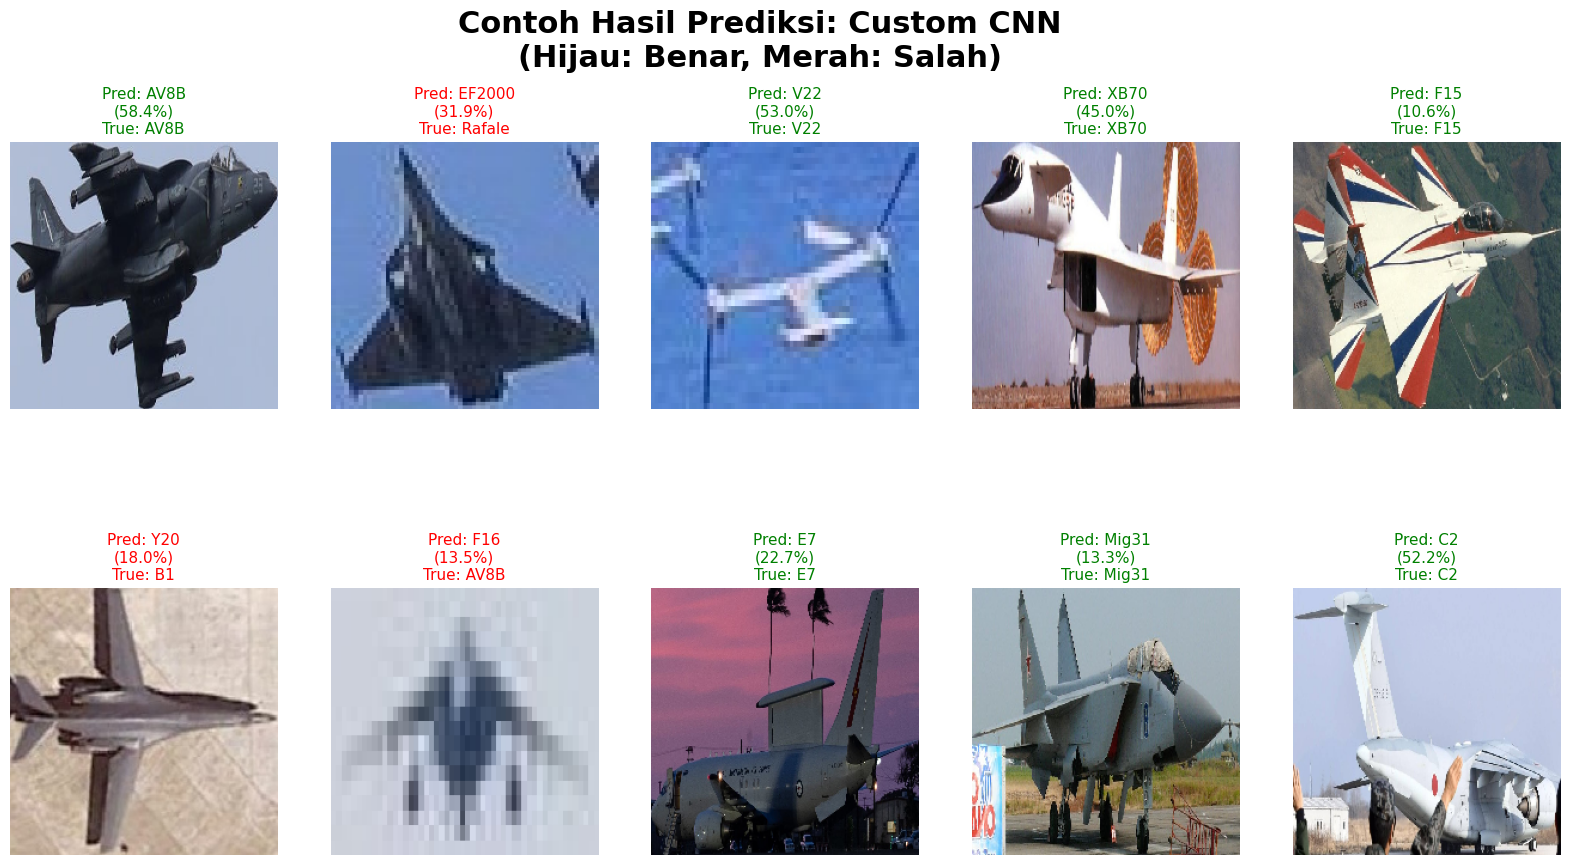


[VISUALISASI] Membuat Galeri untuk MobileNetV2
[INFO] Galeri MobileNetV2 disimpan di ../Images/Gallery_MobileNetV2.png


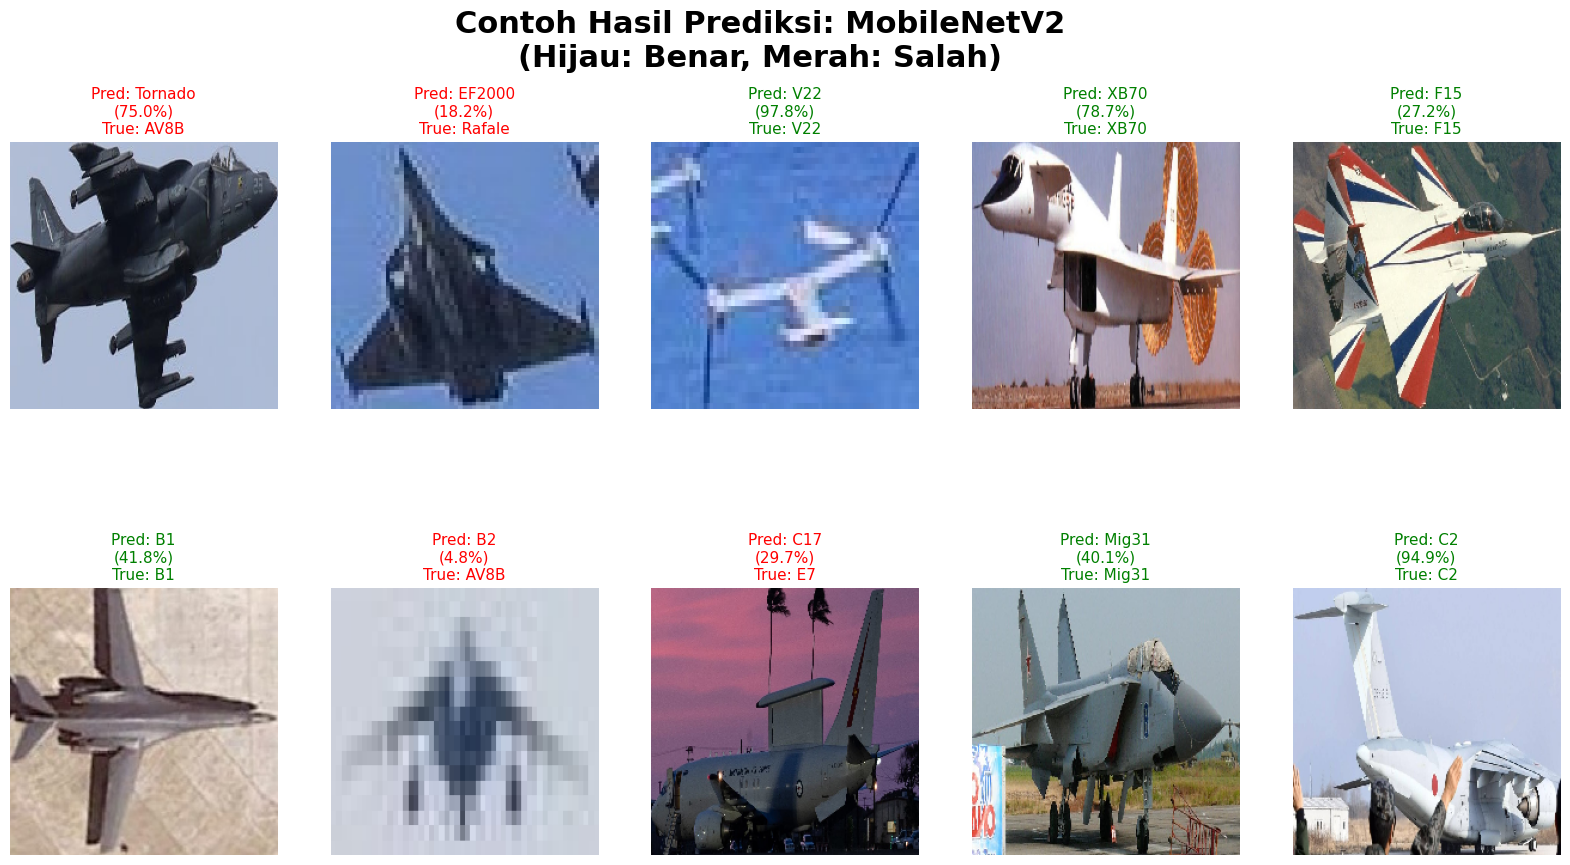


[VISUALISASI] Membuat Galeri untuk EfficientNetB0
[INFO] Galeri EfficientNetB0 disimpan di ../Images/Gallery_EfficientNetB0.png


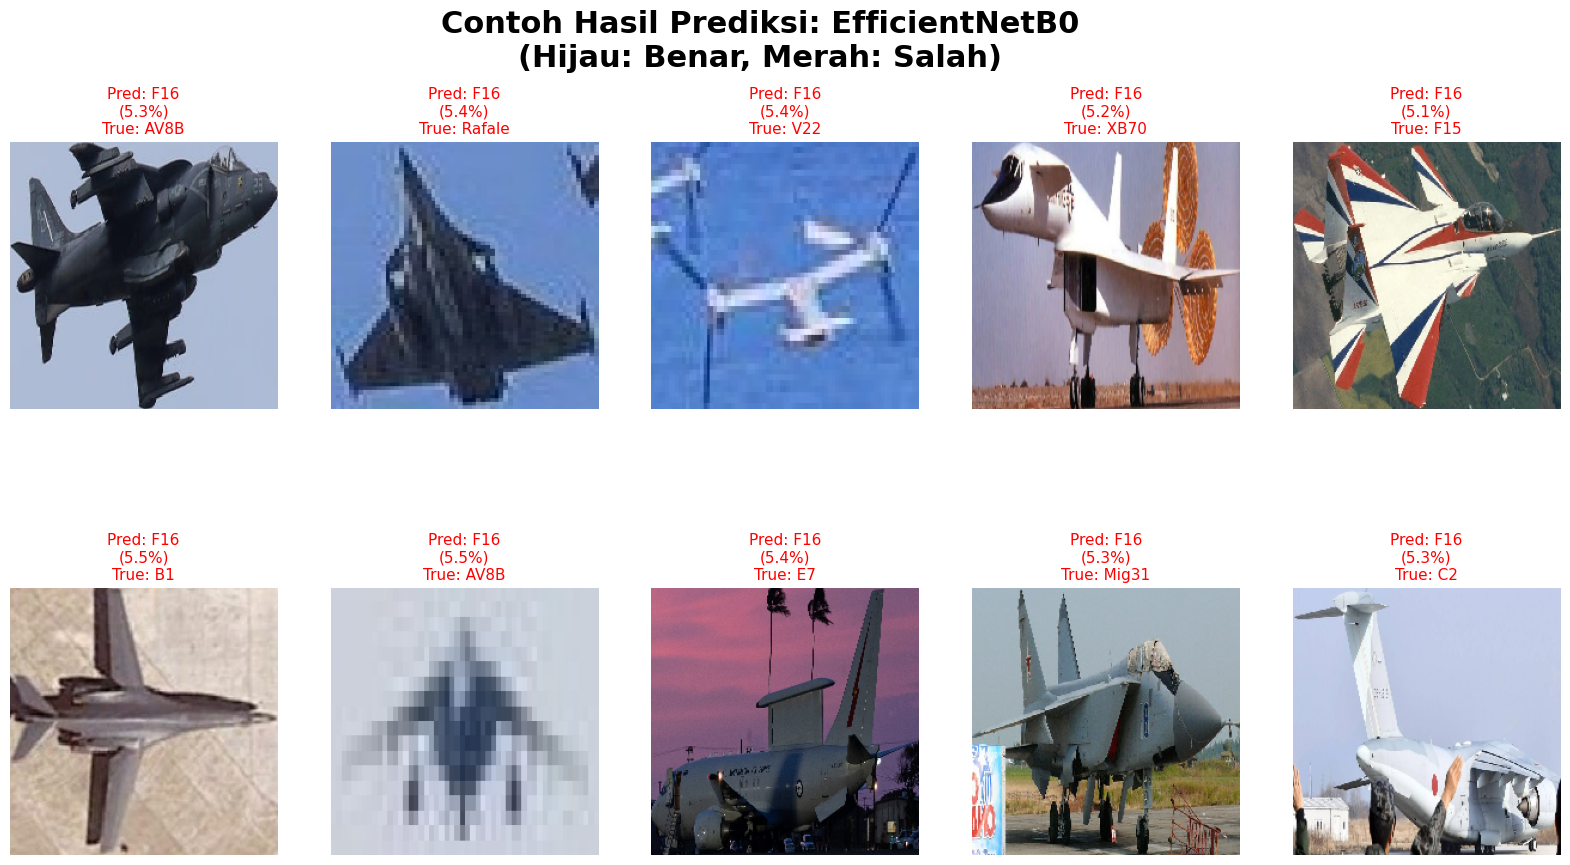

=== VISUALISASI PROBABILITAS (SINGLE IMG) ===

[ANALISIS] Menganalisis gambar untuk Custom CNN...


/tmp/ipykernel_20858/2257500800.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_probs, y=top_5_labels, palette=colors, ax=ax2, orient='h')


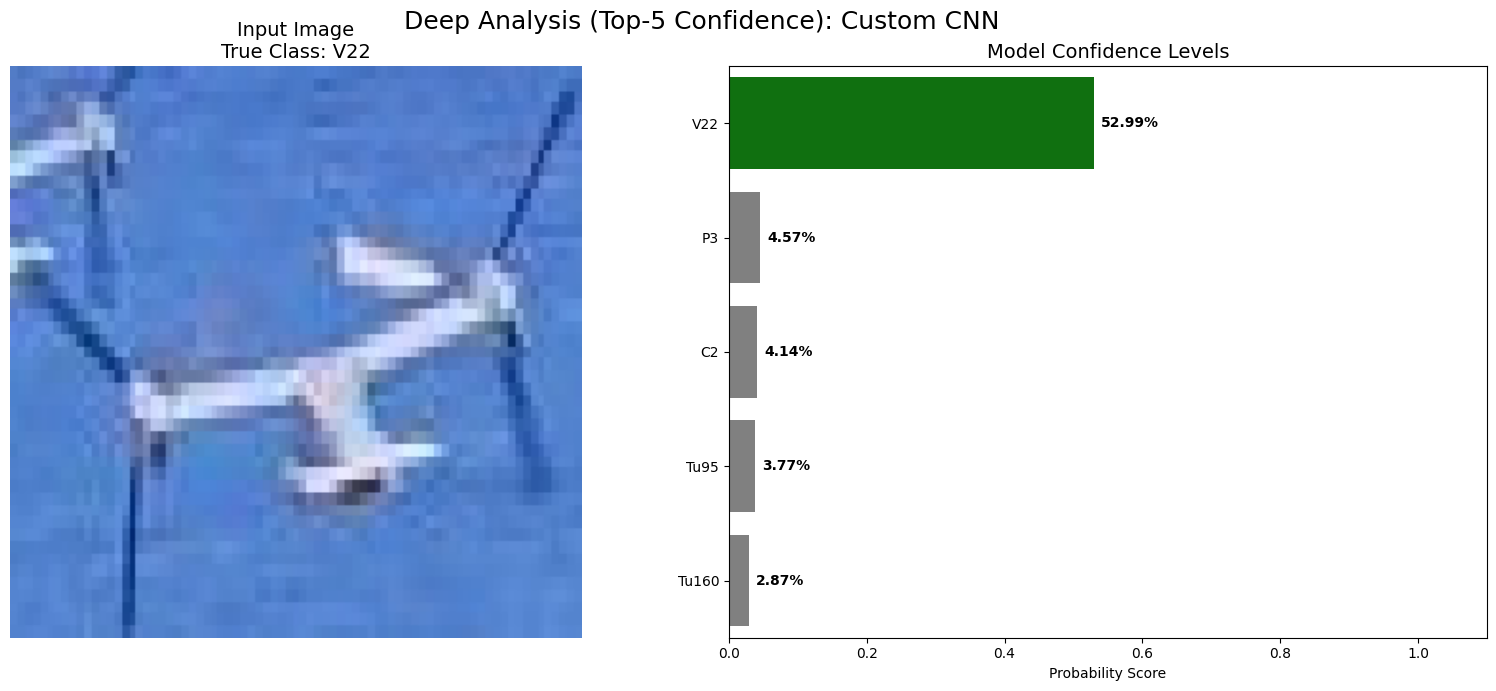


[ANALISIS] Menganalisis gambar untuk MobileNetV2...


/tmp/ipykernel_20858/2257500800.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_probs, y=top_5_labels, palette=colors, ax=ax2, orient='h')


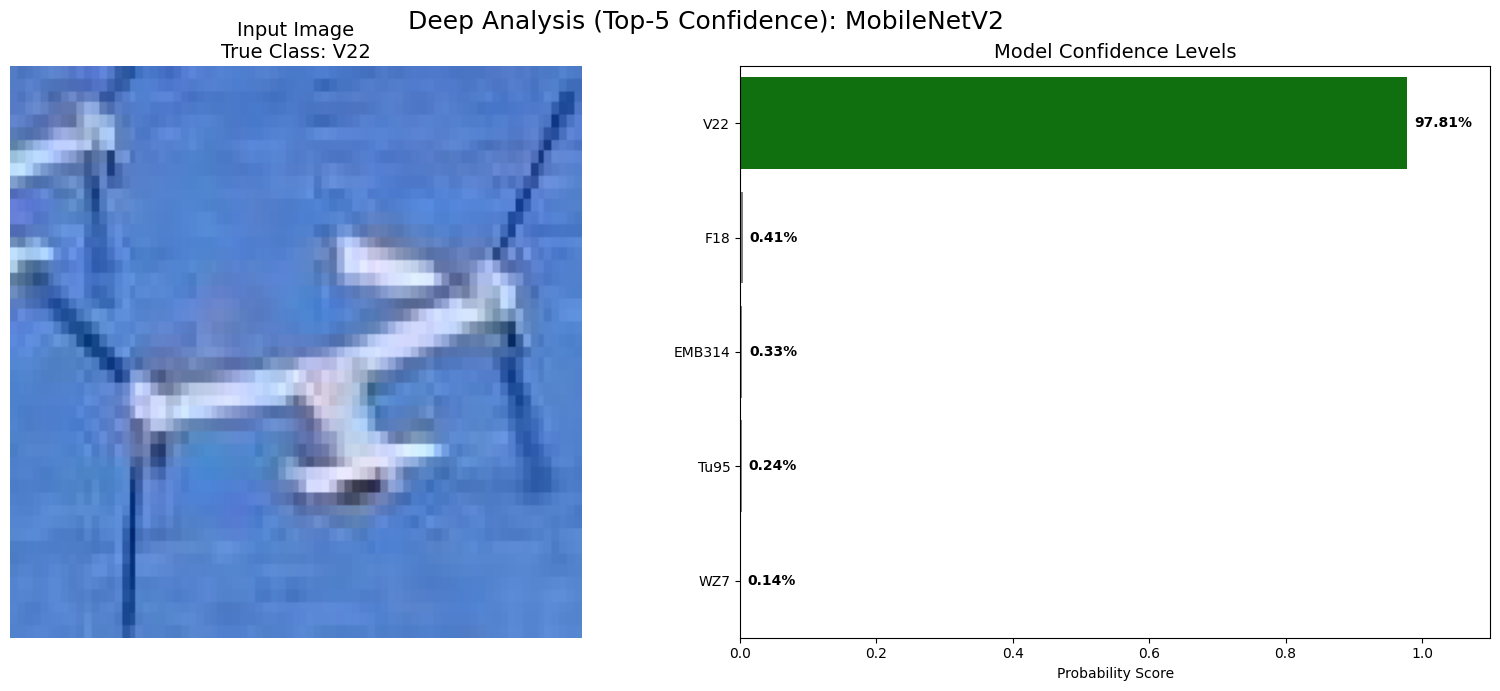


[ANALISIS] Menganalisis gambar untuk EfficientNetB0...


/tmp/ipykernel_20858/2257500800.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_probs, y=top_5_labels, palette=colors, ax=ax2, orient='h')


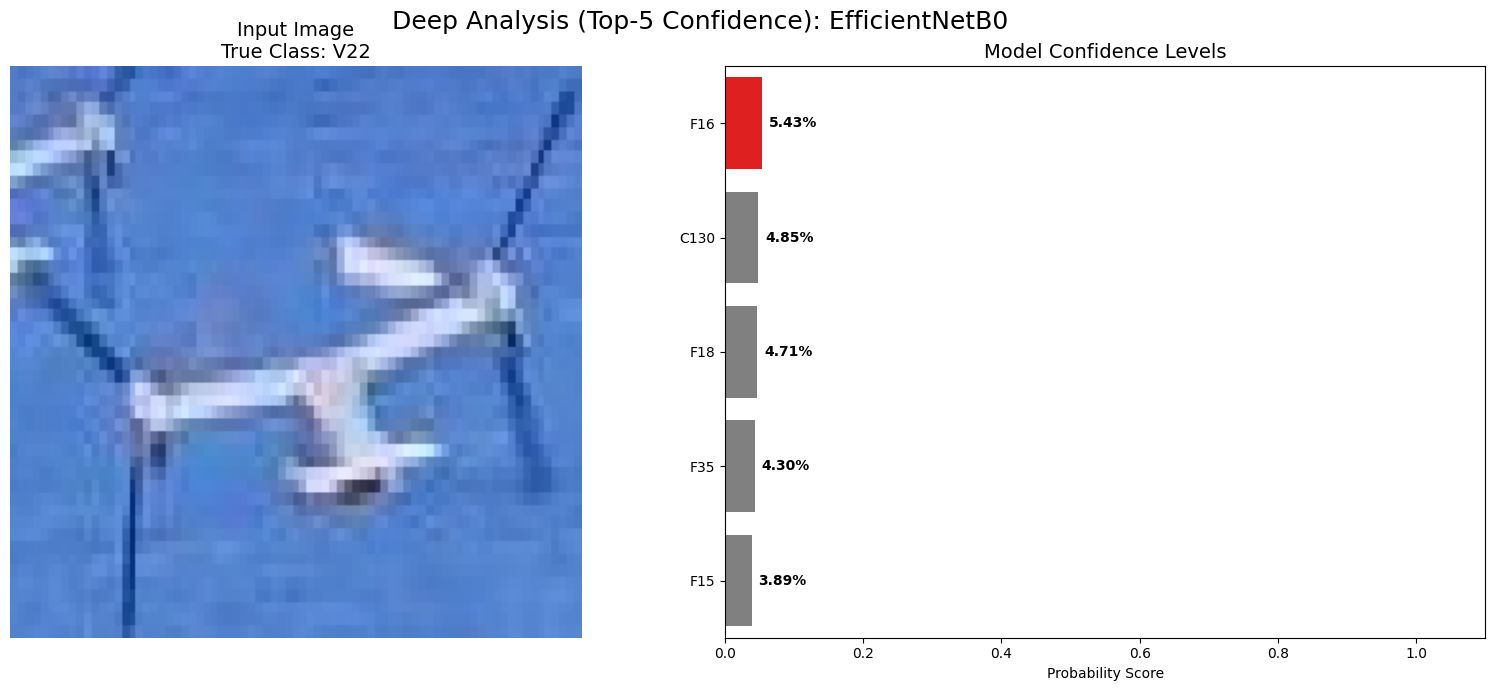

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

os.makedirs("../Images", exist_ok=True)

def visualize_predictions_v2(model, generator, model_name, num_images=15):
    """
    Membuat galeri gambar hasil prediksi untuk analisis kualitatif.
    Args:
        model: Model Keras yang sudah dilatih.
        generator: ImageDataGenerator untuk data uji.
        model_name (str): Nama model untuk judul dan penyimpanan file.
        num_images (int): Jumlah gambar yang akan ditampilkan.
    """
    images, labels = next(generator)
    
    # Prediksi
    preds = model.predict(images, verbose=0) 
    pred_indices = np.argmax(preds, axis=1)
    true_indices = np.argmax(labels, axis=1)
    
    class_names = list(generator.class_indices.keys())
    
    plt.figure(figsize=(20, 16)) 
    plt.subplots_adjust(top=0.90) 
    plt.suptitle(f"Contoh Hasil Prediksi: {model_name}\n(Hijau: Benar, Merah: Salah)", 
                 fontsize=22, y=0.95, weight='bold')
    
    limit = min(num_images, len(images))
    
    for i in range(limit):
        plt.subplot(3, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        
        pred_label = class_names[pred_indices[i]]
        true_label = class_names[true_indices[i]]
        confidence = np.max(preds[i])
        
        color = 'green' if pred_indices[i] == true_indices[i] else 'red'
        
        title = f"Pred: {pred_label}\n({confidence*100:.1f}%)\nTrue: {true_label}"
        plt.title(title, color=color, fontsize=11)
        
    filename = f"Gallery_{model_name.replace(' ', '_')}.png"
    plt.savefig(os.path.join("../Images", filename), bbox_inches='tight')
    print(f"[INFO] Galeri {model_name} disimpan di ../Images/{filename}")
    
    plt.show()

def visualize_single_inference_v2(model, generator, model_name, image_index=0):
    """
    Analisis mendalam satu gambar dengan grafik probabilitas (Bar Chart).
    """
    images, labels = next(generator)
    
    if image_index >= len(images):
        image_index = 0
        
    img = images[image_index]
    true_label_idx = np.argmax(labels[image_index])
    
    img_batch = np.expand_dims(img, axis=0)
    pred_probs = model.predict(img_batch, verbose=0)[0]
    
    class_names = list(generator.class_indices.keys())
    true_label = class_names[true_label_idx]
    
    # Ambil Top 5 Prediksi
    top_5_indices = pred_probs.argsort()[-5:][::-1]
    top_5_probs = pred_probs[top_5_indices]
    top_5_labels = [class_names[i] for i in top_5_indices]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    plt.suptitle(f"Deep Analysis (Top-5 Confidence): {model_name}", fontsize=18, y=0.98)
    
    # Gambar Pesawat
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title(f"Input Image\nTrue Class: {true_label}", fontsize=14)
    
    # Bar Chart Probabilitas
    colors = ['green' if label == true_label else 'gray' for label in top_5_labels]
    if true_label not in top_5_labels:
        colors[0] = 'red' 

    sns.barplot(x=top_5_probs, y=top_5_labels, palette=colors, ax=ax2, orient='h')
    ax2.set_xlim(0, 1.1) 
    ax2.set_xlabel("Probability Score")
    ax2.set_title("Model Confidence Levels", fontsize=14)
    
    for i, v in enumerate(top_5_probs):
        ax2.text(v + 0.01, i, f"{v*100:.2f}%", color='black', va='center', fontweight='bold')
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    
    filename = f"Analysis_{model_name.replace(' ', '_')}_Sample.png"
    plt.savefig(os.path.join("../Images", filename), bbox_inches='tight')
    
    plt.show()

# --- EKSEKUSI UNTUK 3 MODEL SEKALIGUS ---
models_dict = {
    "Custom CNN": model_base,
    "MobileNetV2": model_mobile,
    "EfficientNetB0": model_efficient
}

print("=== VISUALISASI GALERI PREDIKSI (BATCH) ===")

test_generator.reset()

for name, model in models_dict.items():
    print(f"\n[VISUALISASI] Membuat Galeri untuk {name}")
    test_generator.reset() 
    visualize_predictions_v2(model, test_generator, model_name=name, num_images=10)


print("=== VISUALISASI PROBABILITAS (SINGLE IMG) ===")

TARGET_IMG_INDEX = 2 

for name, model in models_dict.items():
    print(f"\n[ANALISIS] Menganalisis gambar untuk {name}...")
    test_generator.reset() 
    visualize_single_inference_v2(model, test_generator, model_name=name, image_index=TARGET_IMG_INDEX)

## Analisis

=== Analisis Profil Komputasi (Industrial Scale) ===
Profiling Custom CNN...
Profiling MobileNetV2...
Profiling EfficientNetB0...
[SAVE] Tabel Metrik Industri disimpan ke: ../Reports/Industrial_Metrics_Summary.csv

Tabel Metrik Industri:


Model  Size (MB)  Inference Time (ms/img)
0      Custom CNN     299.14                     4.99
1     MobileNetV2      24.67                     5.31
2  EfficientNetB0      39.70                     5.38

[SAVE] Grafik Trade-off disimpan ke: ../Images/Analysis_Industrial_Tradeoff.png


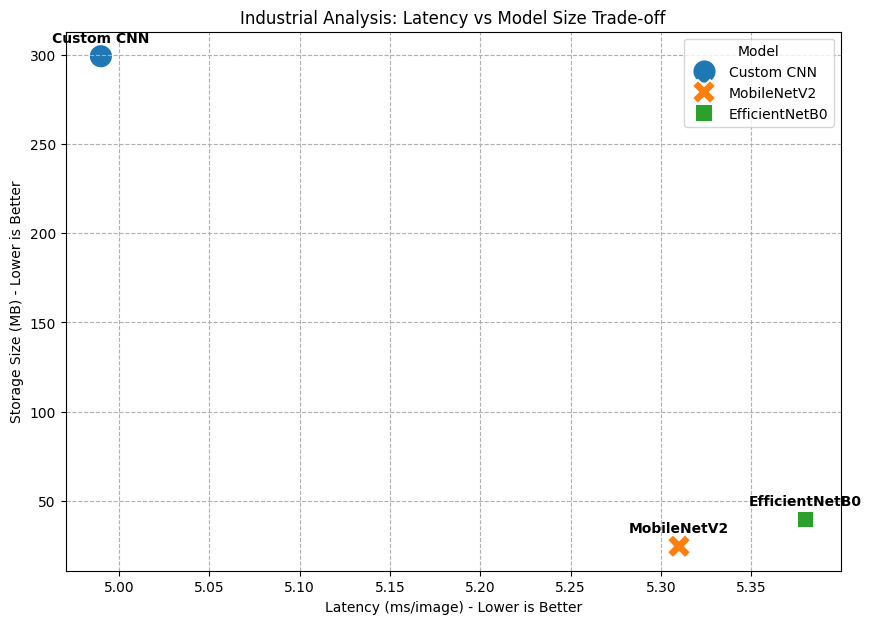


=== Deep Error Analysis (Per-Model Breakdown) ===

--- Menganalisis: Custom CNN ---


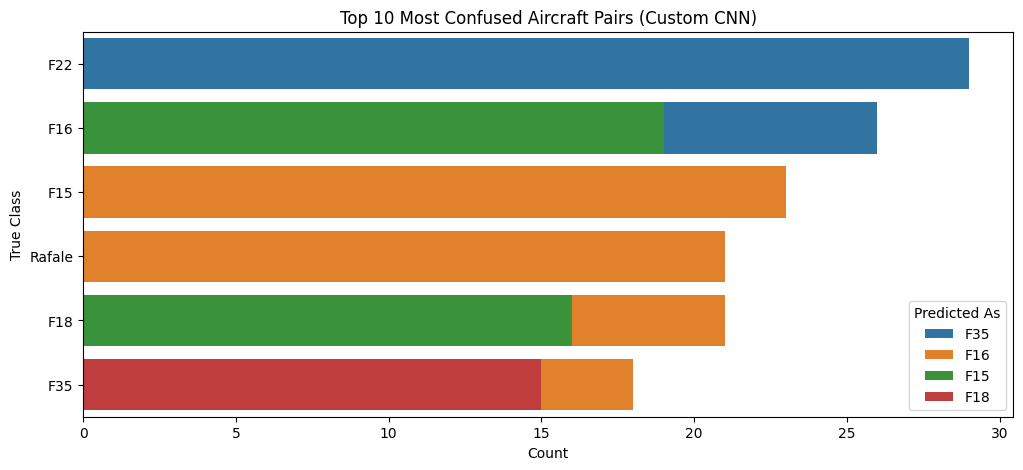

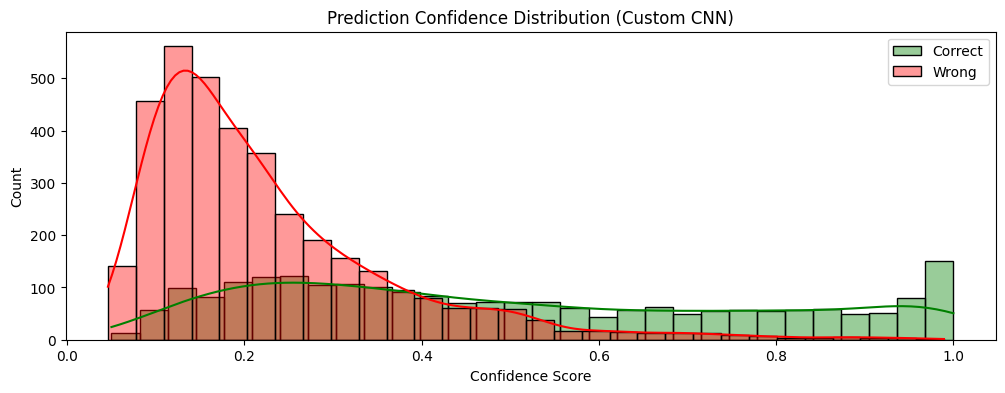

/tmp/ipykernel_20858/1766345113.py:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_perf, x='F1-Score', y='Class', palette='magma')


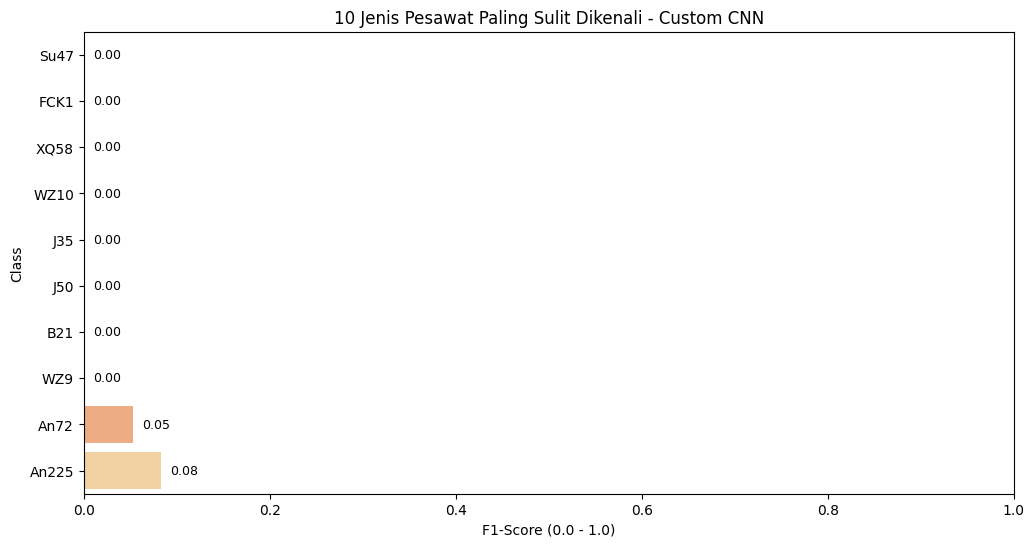

[SAVE] Analisis Custom CNN selesai. Grafik disimpan di ../Images, Tabel di ../Reports

--- Menganalisis: MobileNetV2 ---


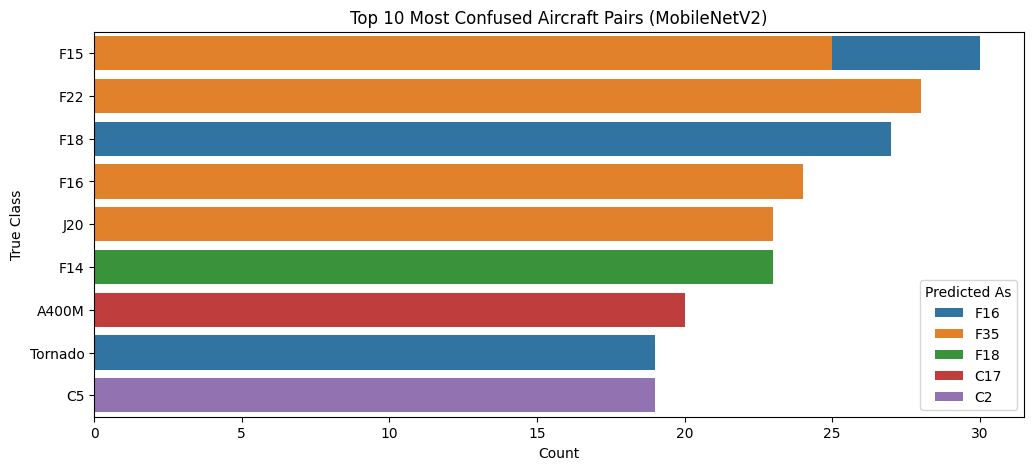

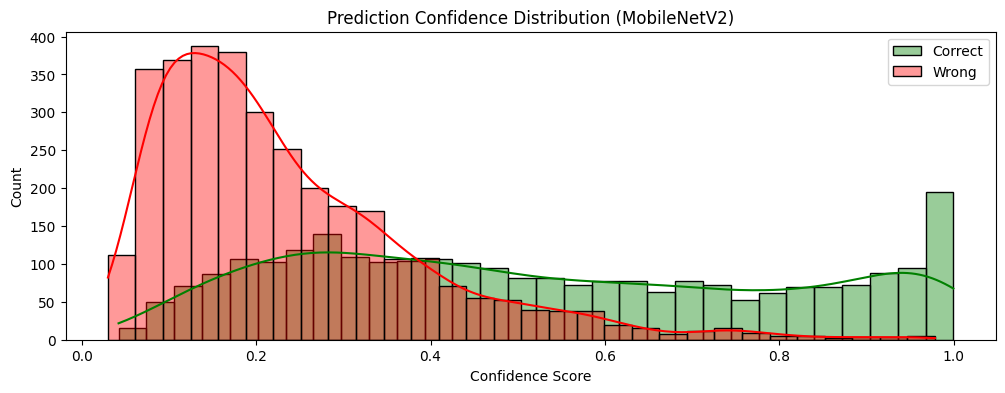

/tmp/ipykernel_20858/1766345113.py:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_perf, x='F1-Score', y='Class', palette='magma')


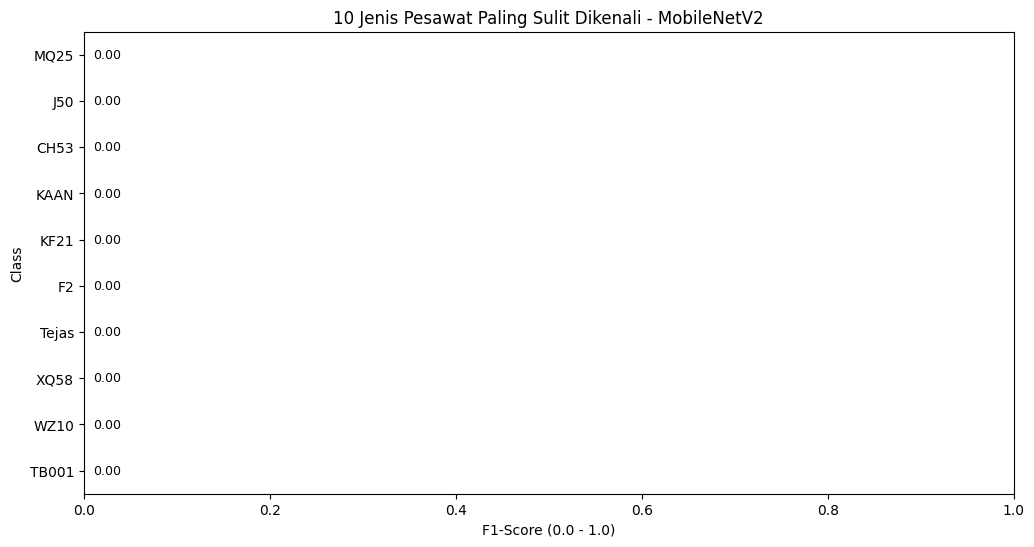

[SAVE] Analisis MobileNetV2 selesai. Grafik disimpan di ../Images, Tabel di ../Reports

--- Menganalisis: EfficientNetB0 ---


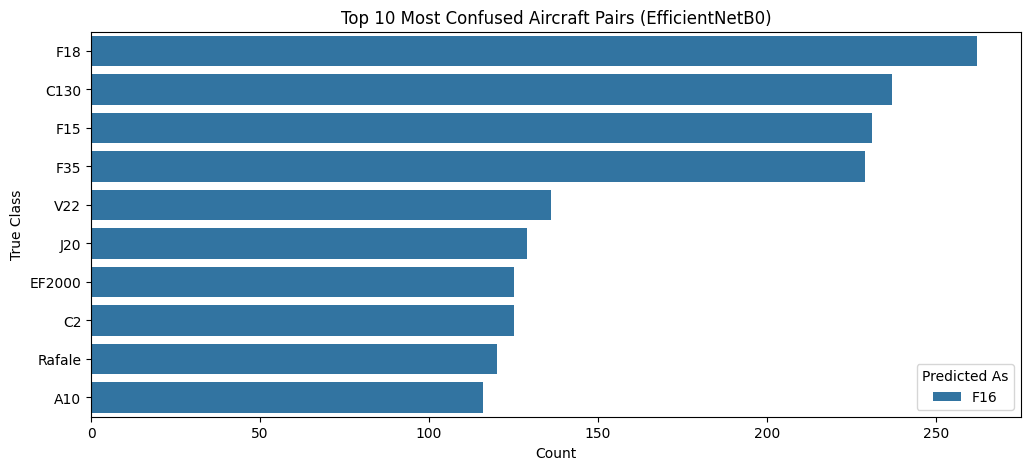

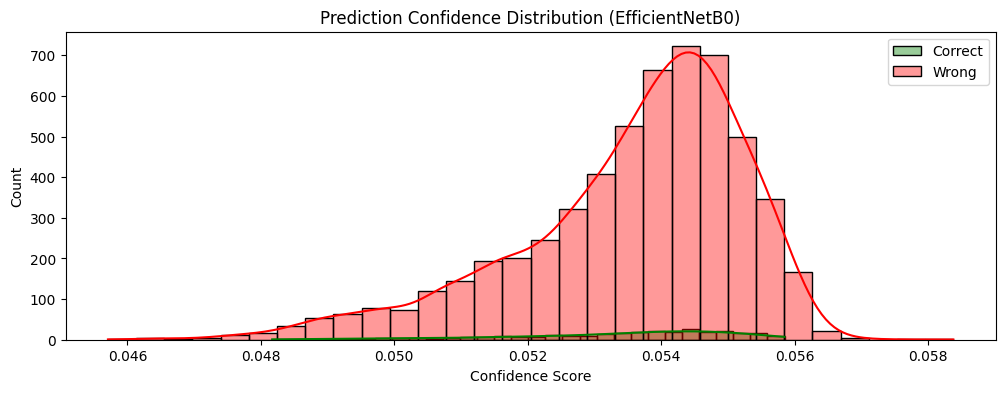

/tmp/ipykernel_20858/1766345113.py:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_perf, x='F1-Score', y='Class', palette='magma')


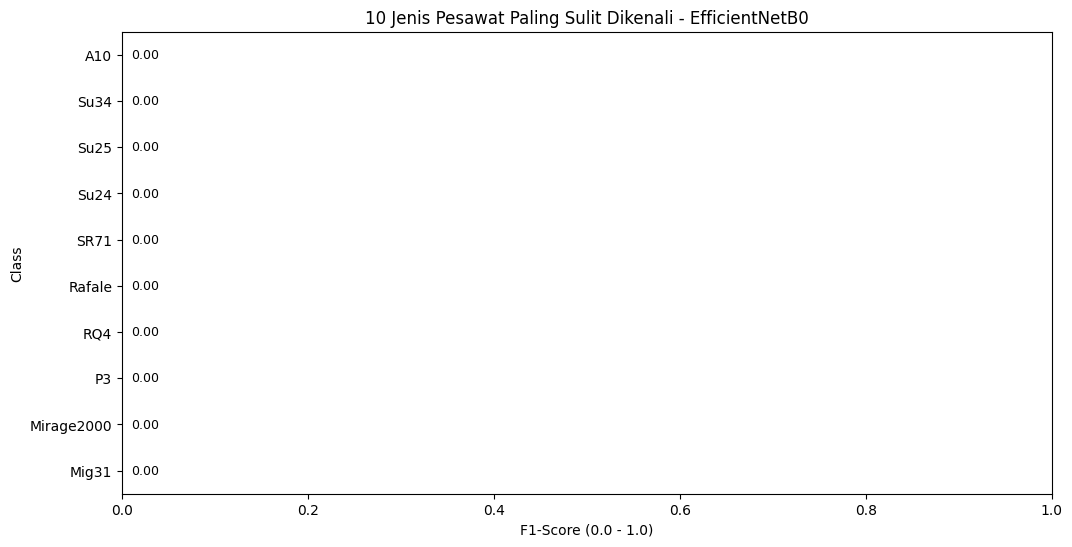

[SAVE] Analisis EfficientNetB0 selesai. Grafik disimpan di ../Images, Tabel di ../Reports


In [26]:
import time
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

MODEL_DIR = '../Models'
IMAGE_DIR = '../Images'
REPORT_DIR = '../Reports'
os.makedirs(IMAGE_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)

def advanced_analysis(models_dict, generator, file_names):
    """
    Melakukan analisis performa model secara komprehensif (Industrial & Research Scale).
    
    Fitur Utama:
    1. Industrial Metrics: Latency vs Size trade-off.
    2. Deep Error Analysis: Confusion pairs & Hardest classes untuk SEMUA model.
    3. Auto-Save: Menyimpan semua plot (PNG) dan tabel (CSV) secara otomatis.

    Args:
        models_dict (dict): Dictionary objek model {nama: model}.
        generator: Test data generator.
        file_names (dict): Dictionary nama file model {nama: filename.h5}.
    """
    
    results = []
    
    # Ambil label kelas sekali saja
    generator.reset()
    y_true = generator.classes
    class_labels = list(generator.class_indices.keys())
    
    print("=== Analisis Profil Komputasi (Industrial Scale) ===")
    
    for name, model in models_dict.items():
        print(f"Profiling {name}...")
        
        # --- A. Pengukuran Ukuran Model ---
        filename = file_names[name]
        file_path_dir = os.path.join(MODEL_DIR, filename)
        
        # Logika pencarian file yang robust
        if os.path.exists(file_path_dir):
            target_path = file_path_dir
        elif os.path.exists(filename):
            target_path = filename
        else:
            print(f"[WARNING] File {filename} tidak ditemukan. Ukuran diset 0.")
            target_path = None
            
        size_mb = os.path.getsize(target_path) / (1024 * 1024) if target_path else 0
        
        # --- B. Pengukuran Latensi Inferensi ---
        # Warm-up GPU
        _ = model.predict(generator[0][0], verbose=0)
        
        start_time = time.time()
        # Prediksi seluruh dataset
        preds = model.predict(generator, verbose=0)
        end_time = time.time()
        
        latency_ms = ((end_time - start_time) / generator.n) * 1000 
        
        # Simpan hasil prediksi untuk analisis tahap 2
        y_pred_idx = np.argmax(preds, axis=1)
        confidence_scores = np.max(preds, axis=1)
        
        results.append({
            'Model': name,
            'Size (MB)': round(size_mb, 2),
            'Inference Time (ms/img)': round(latency_ms, 2),
            'Predictions': y_pred_idx,
            'Confidences': confidence_scores
        })
        
    results_df = pd.DataFrame(results)
    
    # --- C. Simpan Tabel Metrik Industri ---
    industrial_csv = os.path.join(REPORT_DIR, 'Industrial_Metrics_Summary.csv')
    results_df[['Model', 'Size (MB)', 'Inference Time (ms/img)']].to_csv(industrial_csv, index=False)
    print(f"[SAVE] Tabel Metrik Industri disimpan ke: {industrial_csv}")
    print("\nTabel Metrik Industri:")
    display(results_df[['Model', 'Size (MB)', 'Inference Time (ms/img)']])
    
    # --- D. Visualisasi Trade-off ---
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=results_df, x='Inference Time (ms/img)', y='Size (MB)', hue='Model', s=300, style='Model')
    
    for i in range(results_df.shape[0]):
        plt.text(
            results_df['Inference Time (ms/img)'][i], 
            results_df['Size (MB)'][i] + (results_df['Size (MB)'].max() * 0.02), 
            f"{results_df['Model'][i]}", 
            fontsize=10, 
            weight='bold',
            ha='center', 
            va='bottom'  
        )
                 
    plt.title("Industrial Analysis: Latency vs Model Size Trade-off")
    plt.grid(True, linestyle='--')
    plt.xlabel("Latency (ms/image) - Lower is Better")
    plt.ylabel("Storage Size (MB) - Lower is Better")
    
    # Simpan Plot
    plot_path = os.path.join(IMAGE_DIR, 'Analysis_Industrial_Tradeoff.png')
    plt.savefig(plot_path, bbox_inches='tight')
    print(f"[SAVE] Grafik Trade-off disimpan ke: {plot_path}")
    plt.show()
    
    # DEEP ERROR ANALYSIS (UNTUK SEMUA MODEL)    
    print("\n=== Deep Error Analysis (Per-Model Breakdown) ===")
    
    for index, row in results_df.iterrows():
        model_name = row['Model']
        y_pred = row['Predictions']
        confidences = row['Confidences']
        
        safe_name = model_name.replace(' ', '_')
        print(f"\n--- Menganalisis: {model_name} ---")
        
        # --- A. Top-10 Confused Pairs ---
        cm = confusion_matrix(y_true, y_pred)
        np.fill_diagonal(cm, 0) 
        
        pairs = []
        for i in range(len(class_labels)):
            for j in range(len(class_labels)):
                if cm[i, j] > 0:
                    pairs.append({
                        'True Class': class_labels[i], 
                        'Predicted As': class_labels[j], 
                        'Count': cm[i, j]
                    })
        
        df_confused = pd.DataFrame(pairs).sort_values(by='Count', ascending=False).head(10)
        
        # Simpan CSV Confused Pairs
        confused_csv = os.path.join(REPORT_DIR, f'Confused_Pairs_{safe_name}.csv')
        df_confused.to_csv(confused_csv, index=False)
        
        # Plot Bar Chart
        plt.figure(figsize=(12, 5))
        sns.barplot(data=df_confused, y='True Class', x='Count', hue='Predicted As', dodge=False)
        plt.title(f"Top 10 Most Confused Aircraft Pairs ({model_name})")
        
        plot_confused_path = os.path.join(IMAGE_DIR, f'Analysis_Confused_{safe_name}.png')
        plt.savefig(plot_confused_path, bbox_inches='tight')
        plt.show()
        
        # --- B. Confidence Distribution ---
        correct_mask = (y_pred == y_true)
        correct_confs = confidences[correct_mask]
        wrong_confs = confidences[~correct_mask]
        
        plt.figure(figsize=(12, 4))
        sns.histplot(correct_confs, color='green', label='Correct', kde=True, bins=30, alpha=0.4)
        sns.histplot(wrong_confs, color='red', label='Wrong', kde=True, bins=30, alpha=0.4)
        plt.title(f"Prediction Confidence Distribution ({model_name})")
        plt.xlabel("Confidence Score")
        plt.legend()
        
        plot_conf_path = os.path.join(IMAGE_DIR, f'Analysis_Confidence_{safe_name}.png')
        plt.savefig(plot_conf_path, bbox_inches='tight')
        plt.show()

        # --- C. Hardest Classes (Lowest F1-Score) ---
        report_dict = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True, zero_division=0)
        
        class_perf = []
        for label in class_labels:
            if label in report_dict:
                class_perf.append({
                    'Class': label,
                    'F1-Score': report_dict[label]['f1-score'],
                    'Support': report_dict[label]['support']
                })
                
        df_perf = pd.DataFrame(class_perf).sort_values(by='F1-Score', ascending=True).head(10)
        
        hardest_csv = os.path.join(REPORT_DIR, f'Hardest_Classes_{safe_name}.csv')
        df_perf.to_csv(hardest_csv, index=False)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(data=df_perf, x='F1-Score', y='Class', palette='magma')
        plt.title(f"10 Jenis Pesawat Paling Sulit Dikenali - {model_name}")
        plt.xlabel("F1-Score (0.0 - 1.0)")
        plt.xlim(0, 1.0)
        
        for idx, value in enumerate(df_perf['F1-Score']):
            plt.text(value + 0.01, idx, f"{value:.2f}", va='center', fontsize=9)
            
        plot_hardest_path = os.path.join(IMAGE_DIR, f'Analysis_Hardest_Classes_{safe_name}.png')
        plt.savefig(plot_hardest_path, bbox_inches='tight')
        plt.show()
        
        print(f"[SAVE] Analisis {model_name} selesai. Grafik disimpan di {IMAGE_DIR}, Tabel di {REPORT_DIR}")

# EKSEKUSI ANALISIS
models_collection = {
    'Custom CNN': model_base,
    'MobileNetV2': model_mobile,
    'EfficientNetB0': model_efficient
}

filenames_collection = {
    'Custom CNN': 'model_custom_cnn.h5',
    'MobileNetV2': 'model_mobilenetv2_finetuned.h5',
    'EfficientNetB0': 'model_efficientnet_finetuned.h5'
}

advanced_analysis(models_collection, test_generator, filenames_collection)